# AMD-SM2L Joint Project

<a target="_blank" href="https://colab.research.google.com/github/simonemalesardi/AMD_SM2L-Joint_Project/blob/main/amd_sm2l_project.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

* **Author**: Simone Malesardi
* **University**: Università degli Studi Di Milano - Master's Degree Computer science 
* **Academic Year**: 22/23

## 1. Introduction
This project is built over the "IBM Transactions for Anti Money Laundering" dataset sourced from <a href="https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml">Kaggle</a> and released under the Community Data License Agreement. 

The initial request was to create an algorithm that can predict whether a transaction is laundering or legitimate. To achieve this, a learning algorithm for decision trees was developed from scratch and tested on multiple subsets of the data set that can be loaded into main memory.
A random forest algorithm was also implemented using the parallel processing environment provided by Apache Spark, with the aim of providing a comprehensive and scalable system for predicting illicit transactions.

The proposed solution also addresses the imbalance between classes in the data set. This is particularly important since the rate of illicit transactions is extremely low. To ensure the effectiveness of the proposed solutions, the hardware characteristics of the machine on which the entire project was implemented must also be taken into consideration.

<u>*The notebook contains several save checkpoints (spark dataframes are saved in parquet) because during analyses, feature calculations and model creation take time and memory resources. This avoids rerunning all the code*</u>

### 1.1 Setup
The following are the import and related installation commands of all the libraries that are used in the project

In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns 
from pathlib import Path
import math
from math import isnan, ceil

import matplotlib.pyplot as plt

import itertools
from collections import Counter
from enum import Enum

import warnings

########## START - PYSPARK ##########
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, to_timestamp, monotonically_increasing_id, \
    desc, sum as _sum, min as _min, max as _max, rand, when, \
    datediff, dayofmonth, weekofyear, month, year, hour, dayofweek, \
    unix_timestamp, array, lit, round as _round

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer 
########## END - PYSPARK ##########

########## START - SKLEARN ##########
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
########## END - SKLEARN ##########

A datasets folder is created in the project in order to contain:
- datasets downloaded from Kaggle
- the datasets generated in the notebook

In [2]:
datasets_folder = 'datasets'
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)
    print(f"The '{datasets_folder}' folder has been created.")
else:
    print(f"The '{datasets_folder}' folder already exists.")

The 'datasets' folder already exists.


The following code initializes and configures a spark session that will be used to create a DataFrame by reading the csv downloaded with the Kaggle API.

In [3]:
spark = SparkSession.builder \
    .appName("AMD-SM2L Joint Project") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12") \
    .master("local[*]") \
    .getOrCreate()

    
    #spark.sparkContext.setCheckpointDir(".")

spark.sparkContext.setLogLevel("OFF")

:: loading settings :: url = jar:file:/Users/simonemalesardi/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/simonemalesardi/.ivy2/cache
The jars for the packages stored in: /Users/simonemalesardi/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-330d0e99-138a-497a-9421-58b7878e8bb2;1.0
	confs: [default]
	found graphframes#graphframes;0.8.1-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 208ms :: artifacts dl 14ms
	:: modules in use:
	graphframes#graphframes;0.8.1-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	------------

### 1.2 Download files from Kaggle
Download from Kaggle your API token: ensure kaggle.json is the location ~/.kaggle/kaggle.json or upload it

In [4]:
# #from google.colab import files
# print("Please import the API kaggle.json file")
# #files.upload()
# !mkdir -p ~/.kaggle/ 
# !mv .kaggle/kaggle.json ~/.kaggle/ 
# !chmod 600 ~/.kaggle/kaggle.json
# print("kaggle.json imported")

In [5]:
# """
# This file is only used to understand the dataset organization and the pattern types
# !kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml -p datasets -f HI-Small_Patterns.txt 
# """
# !pip install kaggle
# !kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml -f HI-Small_Trans.csv
# !unzip HI-Small_Trans.csv.zip -d datasets/
# !rm HI-Small_Trans.csv.zip

## 2. Analysis
This part consists of exploring the dataset to understand the data distribution and the correlation between them.
Using PySpark, the Apache Spark distributed framework is leveraged to process data across clusters, allowing you to efficiently handle large files by splitting across multiple nodes and reducing execution times.

In [6]:
dataframe = spark.read.csv('datasets/HI-Small_Trans.csv', header=True)
dataframe.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)



A custom schema is written to easily handle both column names and data type in the dataframe.

In [7]:
def get_schema():
    schema = StructType([])

    schema.add('timestamp', StringType(), True)
    schema.add('from_bank', IntegerType(), True)
    schema.add('from_account', StringType(), True)
    schema.add('to_bank', IntegerType(), True)
    schema.add('to_account', StringType(), True)

    schema.add('amount_received', DoubleType(), True) 
    schema.add('receiving_currency', StringType(), True)
    schema.add('amount_paid', DoubleType(), True)
    schema.add('payment_currency', StringType(), True)
    schema.add('payment_format', StringType(), True)
    schema.add('is_laundering', IntegerType(), True)

    return schema

dataframe = spark.read.csv('datasets/HI-Small_Trans.csv', header=False, schema=get_schema())
dataframe = dataframe.filter('timestamp != "Timestamp"') # if this row is omitted, in the dataset will appear 
dataframe.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- from_bank: integer (nullable = true)
 |-- from_account: string (nullable = true)
 |-- to_bank: integer (nullable = true)
 |-- to_account: string (nullable = true)
 |-- amount_received: double (nullable = true)
 |-- receiving_currency: string (nullable = true)
 |-- amount_paid: double (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- payment_format: string (nullable = true)
 |-- is_laundering: integer (nullable = true)



### 2.1 Dataset cleaning
Data cleaning involves the essential task of removing undesirable variables, values, and irregularities from a dataset. These anomalies have the potential to significantly skew the data and consequently impact the results negatively. To achieve a more accurate and reliable analysis, the following steps can be taken for data cleaning:
- Removing missing values
- Identifying and handling duplicated entries

In [8]:
def detecting_duplicates(df):
    grouped_transactions = df.groupBy(df.columns).count()
    number_of_duplicates = grouped_transactions.filter(col("count") > 1)\
        .agg((_sum('count')-count('count')).alias('number_of_duplicates')).toPandas().number_of_duplicates[0]
    
    if isnan(number_of_duplicates):
        number_of_duplicates = 0
        
    grouped_transactions = grouped_transactions.drop('count')
    return number_of_duplicates, grouped_transactions

def clean_and_save(df):
    df.persist()
    original_size = df.count()
    print('Datafram size: {}'.format(original_size))
    
    print('Conversion of timestamps in the following format yyyy/MM/dd HH:mm\n')
    # convert timestamps in a correct format
    df = df.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy/MM/dd HH:mm"))

    print('Finding null values... and transactions removal')
    df = df.dropna()
    new_size = df.count()
    print('Number of removed transactions with null values: {}'.format(original_size-new_size))

    print('Finding duplicated transactions... and transaction removal')
    number_of_duplicates, df = detecting_duplicates(df)
    print('Number of removed of duplicated transactions: {}'.format(number_of_duplicates))

    new_size=new_size-number_of_duplicates
    print('New dataframe size: {}'.format(new_size))
    
    df = df.withColumn("id", monotonically_increasing_id())
    df.write.parquet('datasets/1_cleaned_HI-Small.parquet')
    df.unpersist()

In [9]:
clean_and_save(dataframe)

Datafram size: 5078345
Conversion of timestamps in the following format yyyy/MM/dd HH:mm

Finding null values... and transactions removal


Number of removed transactions with null values: 0
Finding duplicated transactions... and transaction removal


Number of removed of duplicated transactions: 9
New dataframe size: 5078336


### 2.2 Data analysis
The data analysis phase assumes a fundamental role in proceeding with the creation of features and the construction of machine learning models. This essential practice allows you to deeply probe the dataset, revealing crucial insights and recognizing the most relevant variables.

In [10]:
cleaned_df = spark.read.parquet('datasets/1_cleaned_HI-Small.parquet/')
cleaned_df.persist()

dataset_count = cleaned_df.groupBy('is_laundering').count()
print('Number of laundering transactions and legitimate transactions:')
dataset_count.show()
dataset_count = dataset_count.toPandas()

count_laundering = dataset_count.loc[dataset_count['is_laundering'] == 1, 'count'].iloc[0]
count_non_laundering = dataset_count.loc[dataset_count['is_laundering'] == 0, 'count'].iloc[0]
laundering_percentage = count_laundering * 100 /  (count_laundering + count_non_laundering) 
print(f'The percentage of money laundering transactions in the dataset is {round(laundering_percentage,2)}%')

Number of laundering transactions and legitimate transactions:


+-------------+-------+
|is_laundering|  count|
+-------------+-------+
|            1|   5177|
|            0|5073159|
+-------------+-------+

The percentage of money laundering transactions in the dataset is 0.1%


In [11]:
laundering = cleaned_df.filter('is_laundering==1')
non_laundering = cleaned_df.filter('is_laundering==0')

#### 2.2.1 Trend of the sums of money
The graphs below show the amounts of money received (in blue) and paid (in red) grouped by day, week and month.

In [12]:
def draw_bar_line_plot(df, grouped, title, n): 
    plt.subplot(n)
    plt.plot(df[grouped], df['amount_received'], label='Received', color='blue', marker='o', alpha=0.5)
    plt.plot(df[grouped], df['amount_paid'], label='Paid', color='red', marker='o', alpha=0.5)
    plt.xlabel(grouped.capitalize())
    plt.ylabel('Amount')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(df[grouped])
                                    
def trend_amounts(df, df_type):
    df = df.select('timestamp','amount_received','amount_paid')
   
    group_per_day = df.groupBy(year("timestamp").alias("year"), 
                               month("timestamp").alias("month"), 
                               weekofyear("timestamp").alias("week"),
                               dayofmonth("timestamp").alias("day"))\
                                .agg(_sum("amount_received").alias("amount_received"), 
                                     _sum("amount_paid").alias("amount_paid")).orderBy('year','month','day')
    
    group_per_week = group_per_day.groupBy('year', 'month', 'week')\
        .agg(_sum("amount_received").alias("amount_received"), 
             _sum("amount_paid").alias("amount_paid")).orderBy('year','week')

    group_per_month = group_per_week.groupBy('year','month').agg(
        _sum('amount_received').alias('amount_received'),
        _sum('amount_paid').alias('amount_paid')).orderBy('year','month')

    df_pd_day = group_per_day.toPandas()
    df_pd_week = group_per_week.toPandas()
    df_pd_month = group_per_month.toPandas()
    
    plt.figure(figsize=(20, 6))
    draw_bar_line_plot(df_pd_day, 'day', 'Daily Transactions',131)
    draw_bar_line_plot(df_pd_week, 'week', 'Weekly Transactions',132)
    draw_bar_line_plot(df_pd_month, 'month', 'Monthly Transactions',133)
    plt.suptitle('{} - Amounts Grouped By Day, Week & Month'.format(df_type), fontsize=20)
    plt.tight_layout()
    plt.show()

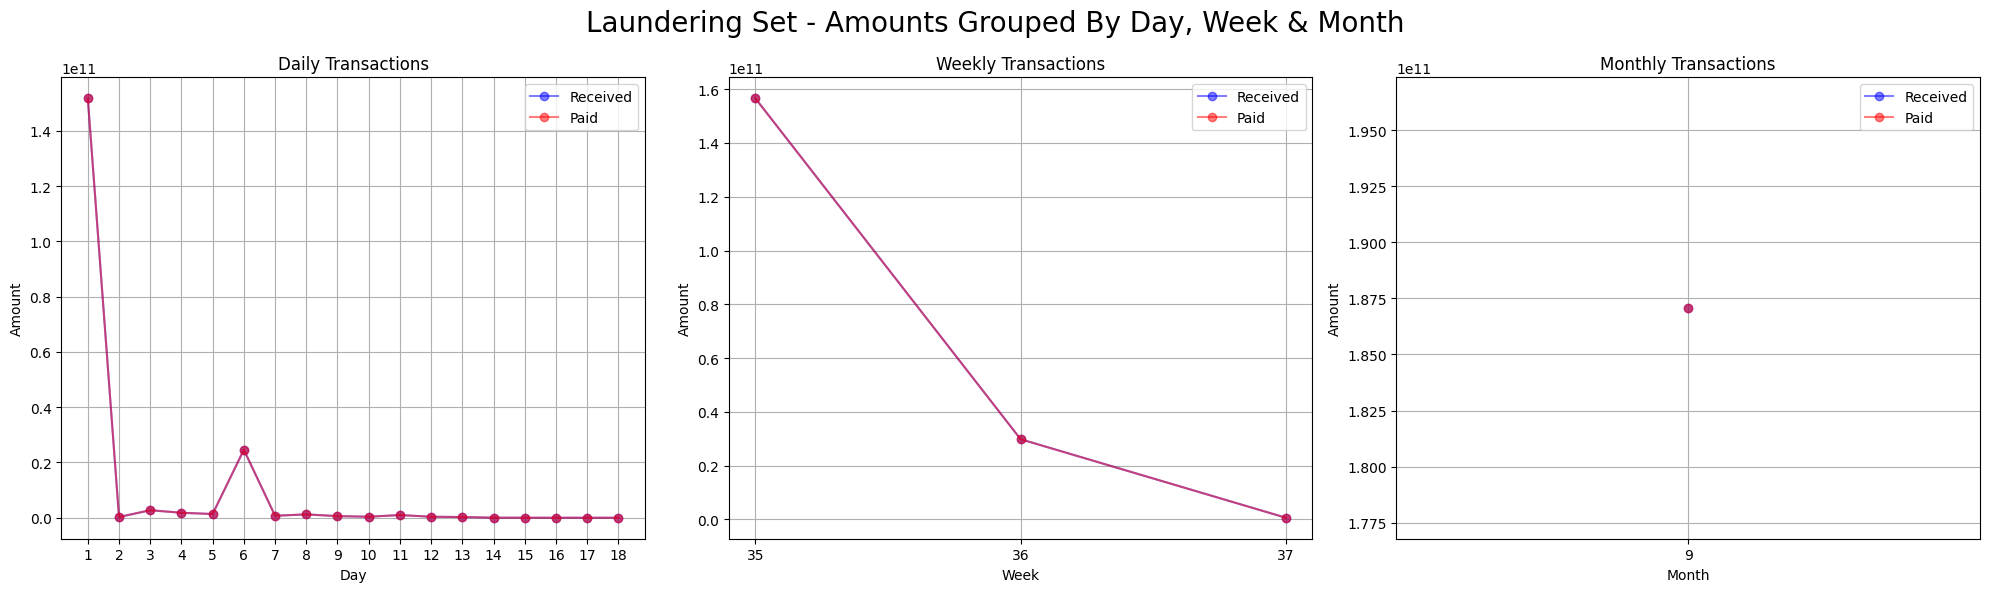

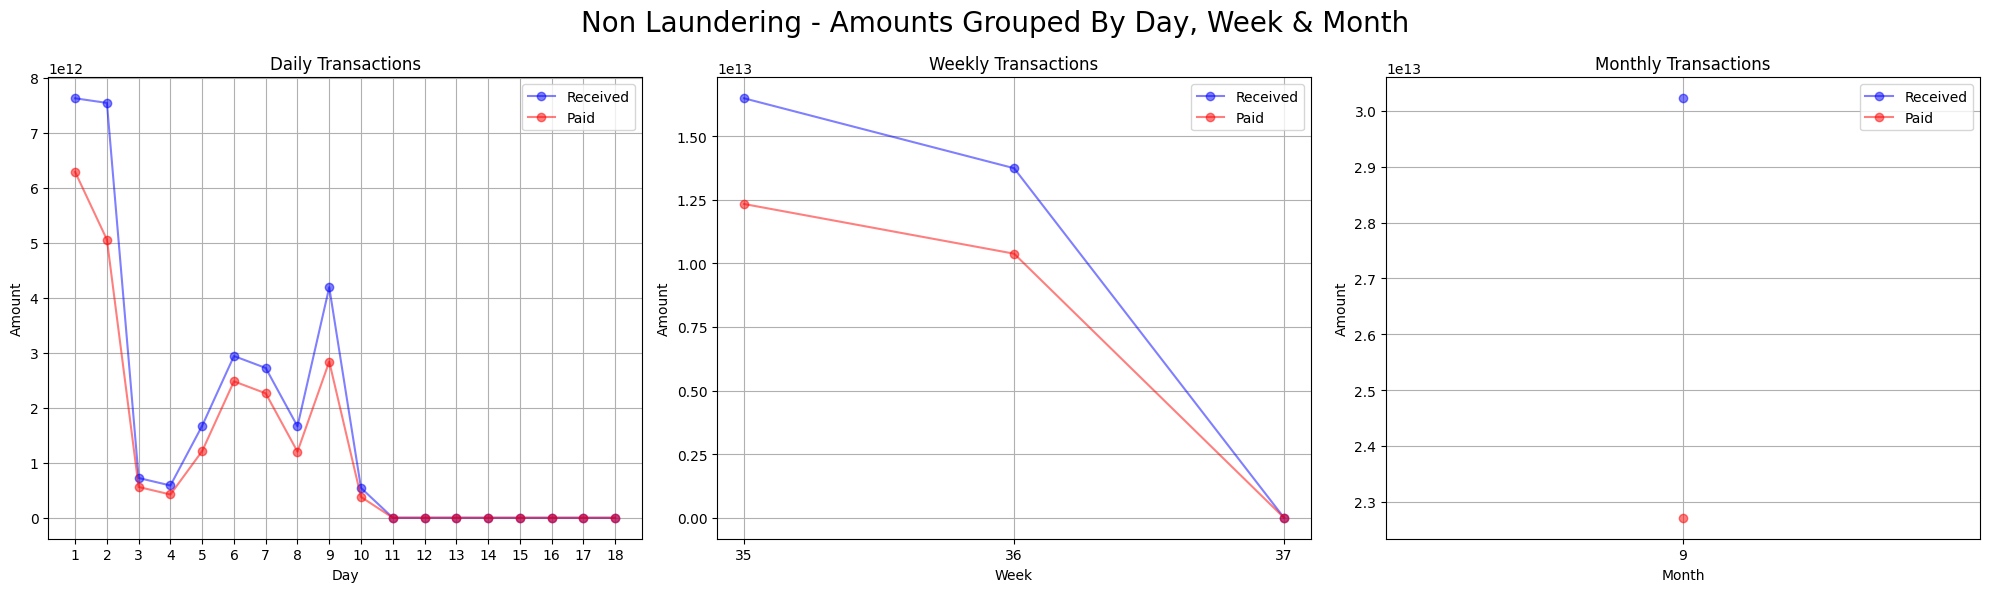

In [13]:
trend_amounts(laundering, 'Laundering Set')
trend_amounts(non_laundering, 'Non Laundering')

As can be easily seen from the graphs of the laundering operations, it seems that the amounts received and paid are always the same, while in the non laundering set the amounts are different. 

In [14]:
amounts = ['amount_received','amount_paid']
print('Description of the amounts of the laundering transasctions')
laundering.select(amounts).describe().show()
print('Description of the amounts of the legitimate transactions')
non_laundering.select(amounts).describe().show()

Description of the amounts of the laundering transasctions
+-------+--------------------+--------------------+
|summary|     amount_received|         amount_paid|
+-------+--------------------+--------------------+
|  count|                5177|                5177|
|   mean| 3.613531041281268E7| 3.613531041281268E7|
| stddev|1.5279186697981353E9|1.5279186697981353E9|
|    min|            0.003227|            0.003227|
|    max|   8.485314417958E10|   8.485314417958E10|
+-------+--------------------+--------------------+

Description of the amounts of the legitimate transactions
+-------+--------------------+-------------------+
|summary|     amount_received|        amount_paid|
+-------+--------------------+-------------------+
|  count|             5073159|            5073159|
|   mean|   5957973.048413484|  4477007.986285359|
| stddev|1.0365643679451811E9| 8.68847067468246E8|
|    min|              1.0E-6|             1.0E-6|
|    max| 1.04630236329348E12|1.04630236329348E12|
+-----

#### 2.2.2 Transactions Per Day

In [15]:
def trend_transactions_x_day(df):
    df = df.select('timestamp','is_laundering')
    group_per_day = df.groupBy(year("timestamp").alias("year"), 
                               month("timestamp").alias("month"), 
                               weekofyear("timestamp").alias("week"),
                               dayofmonth("timestamp").alias("day"),
                               'is_laundering')\
                                .count()\
                                    .orderBy('year','month','day')
   
    laundering_df = group_per_day.filter('is_laundering==1').toPandas()
    non_laundering_df = group_per_day.filter('is_laundering==0').toPandas()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(laundering_df['day'], laundering_df['count'], label='Laundering', marker='o', color='red')
    axes[0].set_xlabel('Day')
    axes[0].set_ylabel('Transactions')
    axes[0].set_title('Number Of Laundering Transactions Per Day')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(non_laundering_df['day'], non_laundering_df['count'], label='NoN Laundering', marker='o', color='blue')
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Transactions')
    axes[1].set_title('Number Of Non Laundering Transactions Per Day')
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle('Number Of Transactions Per Day', fontsize=16)
    plt.tight_layout()
    plt.show()

def draw_laundering_percentage(df, grouped, title, n): 
    plt.subplot(n)
    plt.plot(df[grouped], df['laundering_percentage'], label='Laundering Percentage', color='red', marker='o')
    plt.xlabel(grouped.capitalize())
    plt.ylabel('Percentage')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(df[grouped])

string_to_print = 'Number of laundering transactions and legitimate transactions per {}'
def laundering_percentage(df):
    df = df.select('timestamp', 'is_laundering')
    group_per_day = df.groupBy(year("timestamp").alias("year"), 
                                month("timestamp").alias("month"), 
                                weekofyear("timestamp").alias("week"),
                                dayofmonth("timestamp").alias("day"),
                                'is_laundering')\
                                .agg(count('*').alias('number')).orderBy('year','month','day')

    group_per_day = group_per_day.filter('is_laundering==1').\
        withColumnRenamed('number', 'launderings').join(
            group_per_day.filter('is_laundering==0')\
                .withColumnRenamed('number', 'non_launderings').drop('is_laundering'), ['year','month','week','day'],'fullouter')\
        .na.fill(value=0,subset=['launderings','non_launderings'])\
        .drop('is_laundering')\
        .withColumn('laundering_percentage', ((100*col('launderings'))/(col('launderings')+col('non_launderings'))).cast('Decimal(20,10)'))

    df_pd_day = group_per_day.select('day','launderings', 'non_launderings','laundering_percentage')
    print(string_to_print.format('day'))
    df_pd_day.show(31) #31 = maximum number of days in a month
    df_pd_day = df_pd_day.select('day','laundering_percentage').toPandas()

    group_per_week = group_per_day.groupBy('year', 'month', 'week')\
        .agg(_sum("launderings").alias("launderings"),
             _sum("non_launderings").alias("non_launderings")).orderBy('year','week')

    group_per_week = group_per_week.withColumn('laundering_percentage', ((100*col('launderings'))/(col('launderings')+col('non_launderings'))).cast('Decimal(20,10)'))

    df_pd_week = group_per_week.select('week','launderings', 'non_launderings','laundering_percentage')
    print(string_to_print.format('week'))    
    df_pd_week.show()
    df_pd_week = df_pd_week.select('week','laundering_percentage').toPandas()


    group_per_month = group_per_day.groupBy('year', 'month')\
        .agg(_sum("launderings").alias("launderings"),
             _sum("non_launderings").alias("non_launderings")).orderBy('year','month')
    
    group_per_month = group_per_month.withColumn('laundering_percentage', ((100*col('launderings'))/(col('launderings')+col('non_launderings'))).cast('Decimal(20,10)'))

    df_pd_month = group_per_month.select('month','launderings', 'non_launderings','laundering_percentage')
    print(string_to_print.format('month'))    
    df_pd_month.show()
    df_pd_month = df_pd_month.select('month','laundering_percentage').toPandas()

    plt.figure(figsize=(20, 6))
    draw_laundering_percentage(df_pd_day, 'day', 'Daily Laundering Percentage',131)
    draw_laundering_percentage(df_pd_week, 'week', 'Weekly Laundering Percentage',132)
    draw_laundering_percentage(df_pd_month, 'month', 'Monthly Laundering Percentage',133)
    plt.suptitle('Laundering Percentage Grouped By Day, Week & Month', fontsize=20)
    plt.tight_layout()
    plt.show()

def laundering_percentage_per_day_hour(df):
    df = df.select(dayofweek(col('timestamp')).alias('day_of_the_week'), hour(col('timestamp')).alias('hour'), 'is_laundering')

    group_per_day_of_week = df.groupBy('day_of_the_week',
                                'is_laundering')\
                                .agg(count('*').alias('number')).orderBy('day_of_the_week')
    
    group_per_day_of_week = group_per_day_of_week.filter('is_laundering==1').\
        withColumnRenamed('number', 'launderings').join(
            group_per_day_of_week.filter('is_laundering==0')\
                .withColumnRenamed('number', 'non_launderings').drop('is_laundering'), ['day_of_the_week'],'fullouter')\
        .na.fill(value=0,subset=['launderings','non_launderings'])\
        .drop('is_laundering')\
        .withColumn('laundering_percentage', ((100*col('launderings'))/(col('launderings')+col('non_launderings'))).cast('Decimal(20,10)'))

    print(string_to_print.format('day of the week')) 
    group_per_day_of_week.show()

    group_per_hour = df.groupBy('hour',
                                'is_laundering')\
                                .agg(count('*').alias('number')).orderBy('hour')

    group_per_hour = group_per_hour.filter('is_laundering==1').\
        withColumnRenamed('number', 'launderings').join(
            group_per_hour.filter('is_laundering==0')\
                .withColumnRenamed('number', 'non_launderings').drop('is_laundering'), ['hour'],'fullouter')\
        .na.fill(value=0,subset=['launderings','non_launderings'])\
        .drop('is_laundering')\
        .withColumn('laundering_percentage', ((100*col('launderings'))/(col('launderings')+col('non_launderings'))).cast('Decimal(20,10)'))
    
    print(string_to_print.format('hour of the day')) 
    group_per_hour.show(24) #24 = maximum number of hours in a day

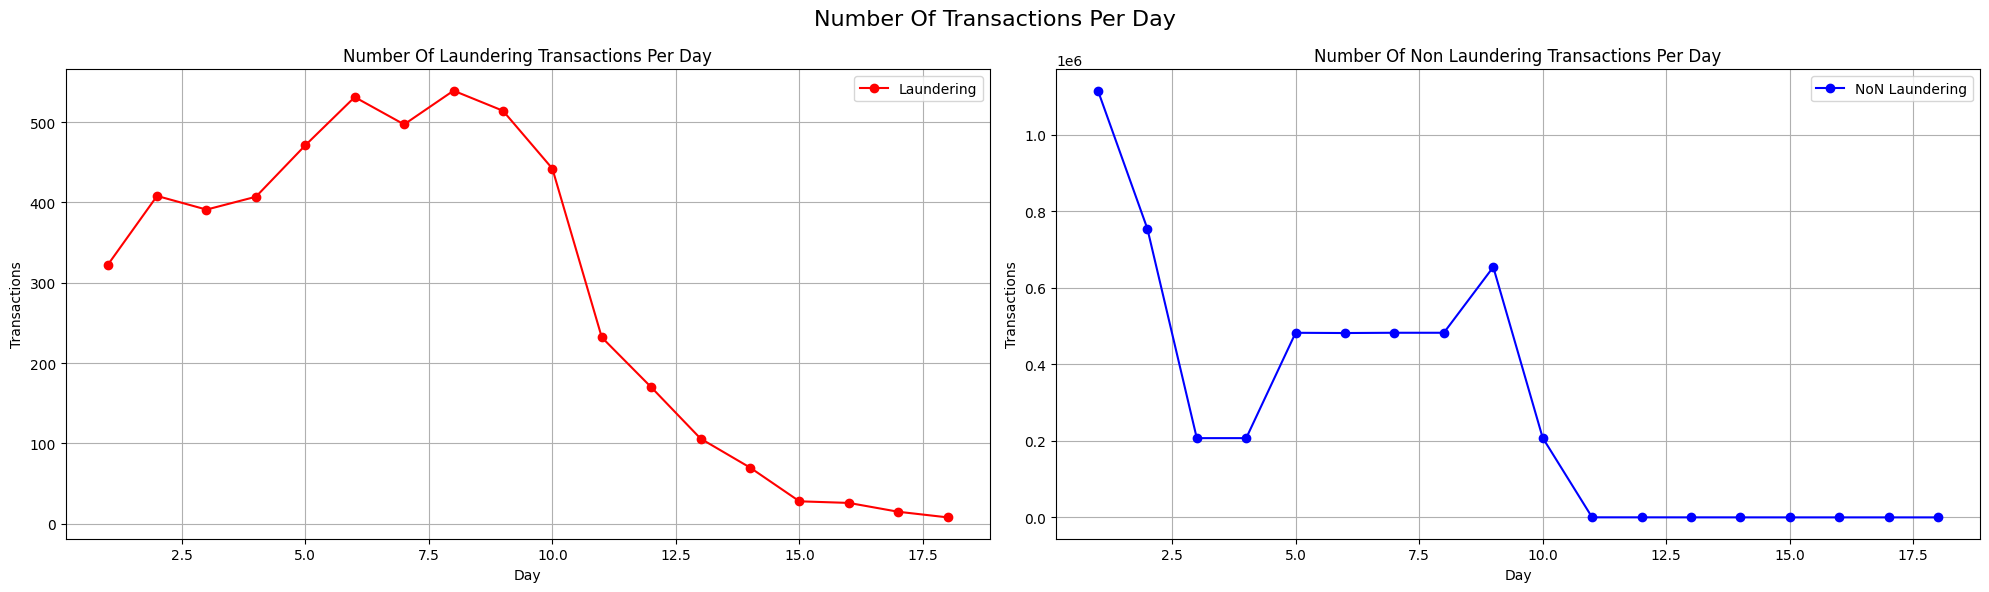

In [16]:
trend_transactions_x_day(cleaned_df)

Number of laundering transactions and legitimate transactions per day


+---+-----------+---------------+---------------------+
|day|launderings|non_launderings|laundering_percentage|
+---+-----------+---------------+---------------------+
|  1|        322|        1114597|         0.0288810219|
|  2|        408|         754041|         0.0540792022|
|  3|        391|         206991|         0.1885409534|
|  4|        407|         207023|         0.1962107699|
|  5|        471|         482179|         0.0975862426|
|  6|        531|         481558|         0.1101456370|
|  7|        497|         482253|         0.1029518384|
|  8|        539|         482232|         0.1116471370|
|  9|        514|         653949|         0.0785376713|
| 10|        442|         207883|         0.2121684867|
| 11|        232|            164|        58.5858585859|
| 12|        170|            111|        60.4982206406|
| 13|        106|             78|        57.6086956522|
| 14|         70|             51|        57.8512396694|
| 15|         28|             18|        60.8695

Number of laundering transactions and legitimate transactions per week
+----+-----------+---------------+---------------------+
|week|launderings|non_launderings|laundering_percentage|
+----+-----------+---------------+---------------------+
|  35|       1528|        2282652|         0.0668949032|
|  36|       3226|        2790218|         0.1154846849|
|  37|        423|            289|        59.4101123596|
+----+-----------+---------------+---------------------+

Number of laundering transactions and legitimate transactions per month
+-----+-----------+---------------+---------------------+
|month|launderings|non_launderings|laundering_percentage|
+-----+-----------+---------------+---------------------+
|    9|       5177|        5073159|         0.1019428411|
+-----+-----------+---------------+---------------------+



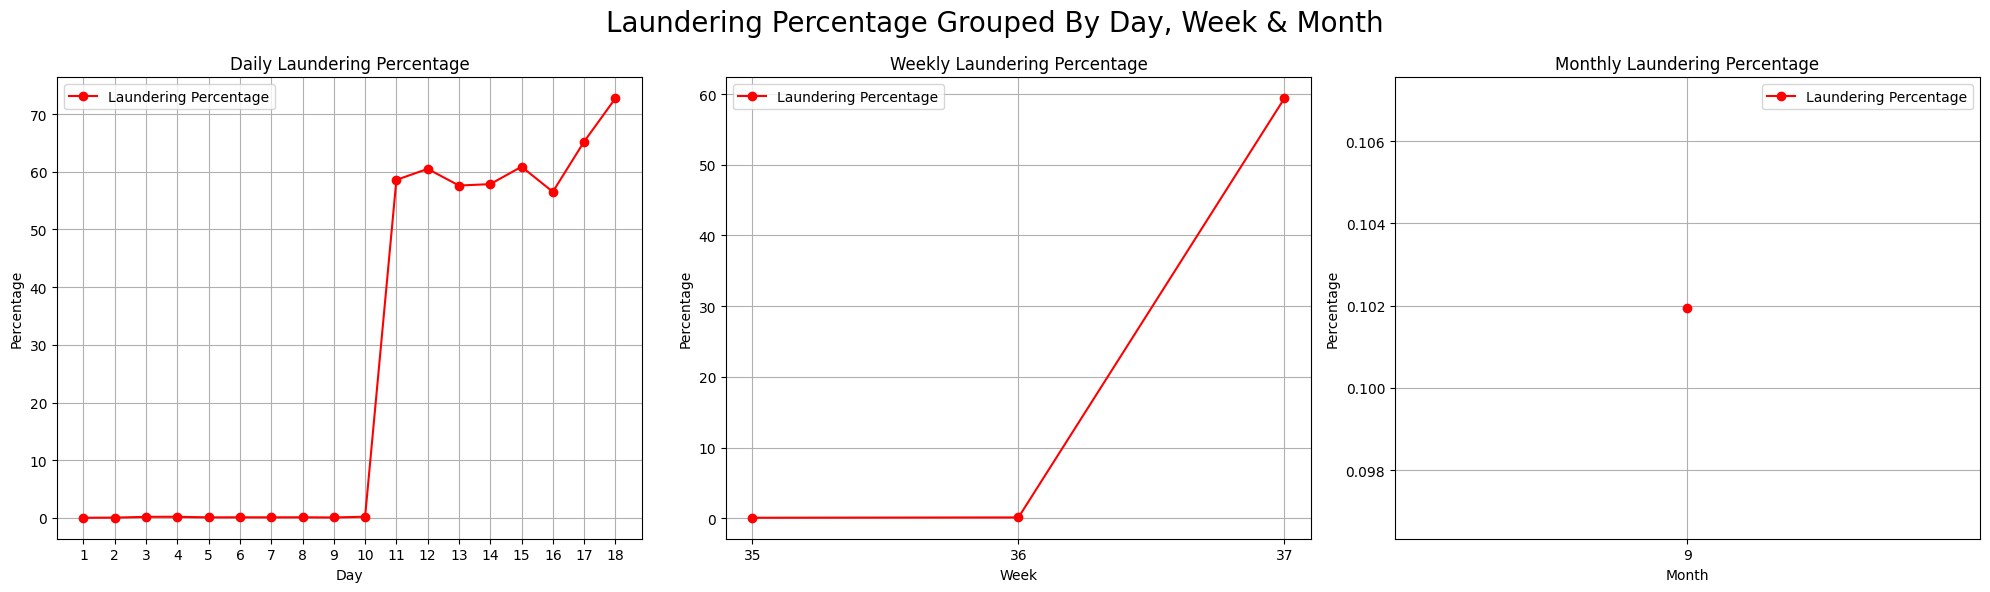

In [17]:
laundering_percentage(cleaned_df)

From the graph above it can be deduced that there is a direct correlation between laundering ytansactions and days.

The number of laundering transactions increases after the 10th day of the month.

A legitimate question that arises is whether at this point there are hours or days of the week when the percentage of laundering operations is higher.

In [18]:
laundering_percentage_per_day_hour(cleaned_df)

Number of laundering transactions and legitimate transactions per day of the week


+---------------+-----------+---------------+---------------------+
|day_of_the_week|launderings|non_launderings|laundering_percentage|
+---------------+-----------+---------------+---------------------+
|              1|        647|         207190|         0.3113016450|
|              2|        641|         482290|         0.1327311769|
|              3|        637|         481636|         0.1320828659|
|              4|        567|         482304|         0.1174226657|
|              5|        889|        1596847|         0.0556412323|
|              6|        948|        1408010|         0.0672837657|
|              7|        848|         414882|         0.2039785438|
+---------------+-----------+---------------+---------------------+

Number of laundering transactions and legitimate transactions per hour of the day
+----+-----------+---------------+---------------------+
|hour|launderings|non_launderings|laundering_percentage|
+----+-----------+---------------+---------------------

It would seem that Sunday and Saturday are the two days of the week with the highest rate of positivity.

As for the hours, it would seem that the mid-day hours are the ones with the highest rate of positives.

#### 2.2.3 Payment Format

In [19]:
def plot_payment_format(df, df_type):
    plt.figure(figsize=(20, 5))
    payment_format = df.groupBy('payment_format').agg(count('*').alias('count')).toPandas()
    plt.bar(payment_format['payment_format'], payment_format['count'])
    plt.xlabel('Payment format')
    plt.ylabel('Number of transactions')
    plt.title('{} - Types of payment format'.format(df_type), fontsize=16)
    plt.show()

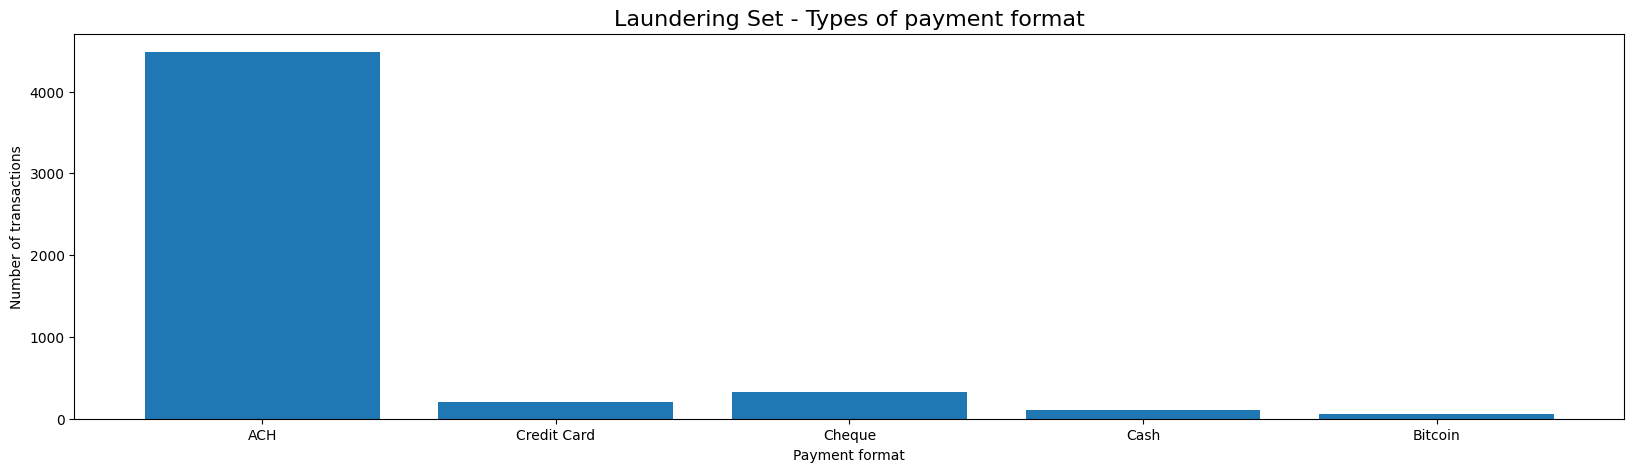

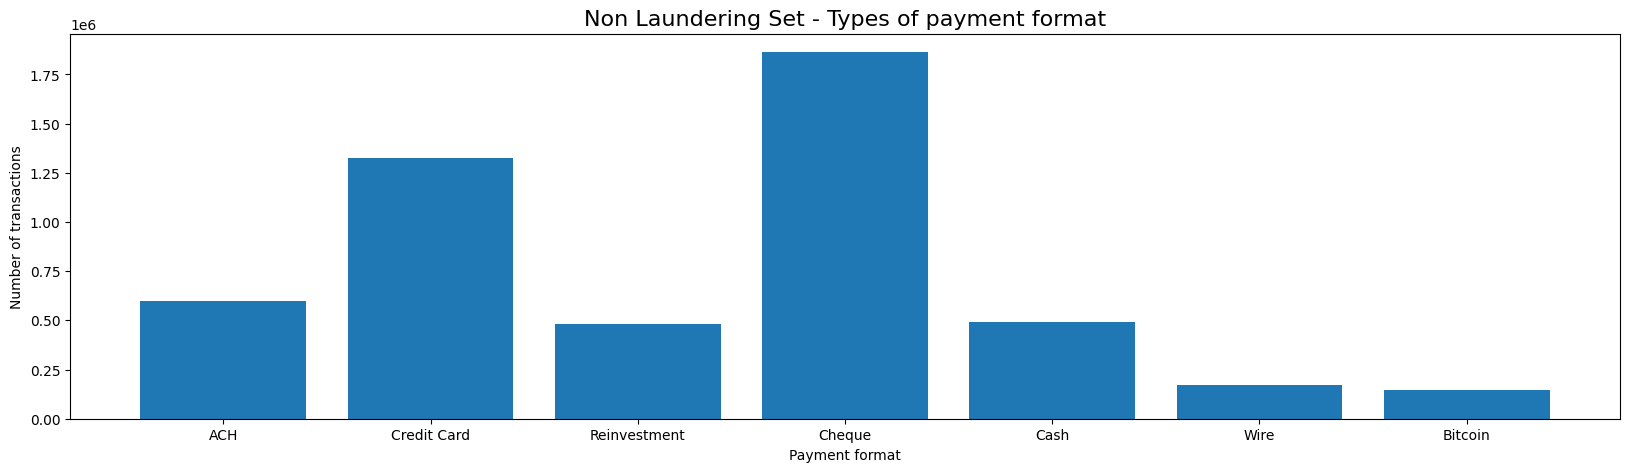

In [20]:
plot_payment_format(laundering, 'Laundering Set')
plot_payment_format(non_laundering, 'Non Laundering Set')

The number of money laundering transactions whose payment format is ACH clearly prevalent over all other types.

#### 2.2.4 Receiving and Payment Currency

In [21]:
def n_currencies(df, df_type):
    currency_t = df.groupBy('receiving_currency').agg(count('*').alias('count')).toPandas()
    currency_f = df.groupBy('payment_currency').agg(count('*').alias('count')).toPandas()

    bar_width = 0.35

    x = range(len(currency_t))

    plt.figure(figsize=(20, 5))

    plt.bar(x, currency_t['count'], width=bar_width, label='Receiving Currency', color='blue')

    plt.bar([i + bar_width for i in x], currency_f['count'], width=bar_width, label='Payment Currency', color='red')

    plt.xlabel('Currency')
    plt.ylabel('Number of transactions')
    plt.title('{} - Types of currencies'.format(df_type), fontsize=16)
    
    plt.xticks([i + bar_width/2 for i in x], [text.replace(" ", "\n") for text in currency_t['receiving_currency']], ha='center')
    
    plt.legend()
    plt.show()

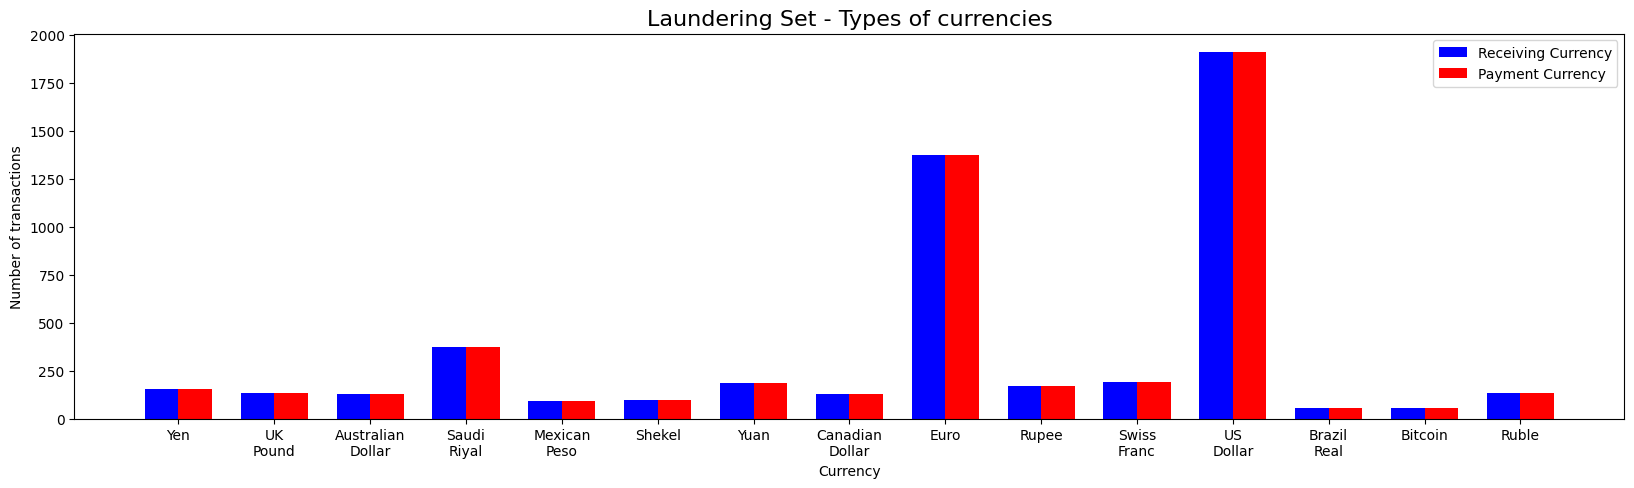

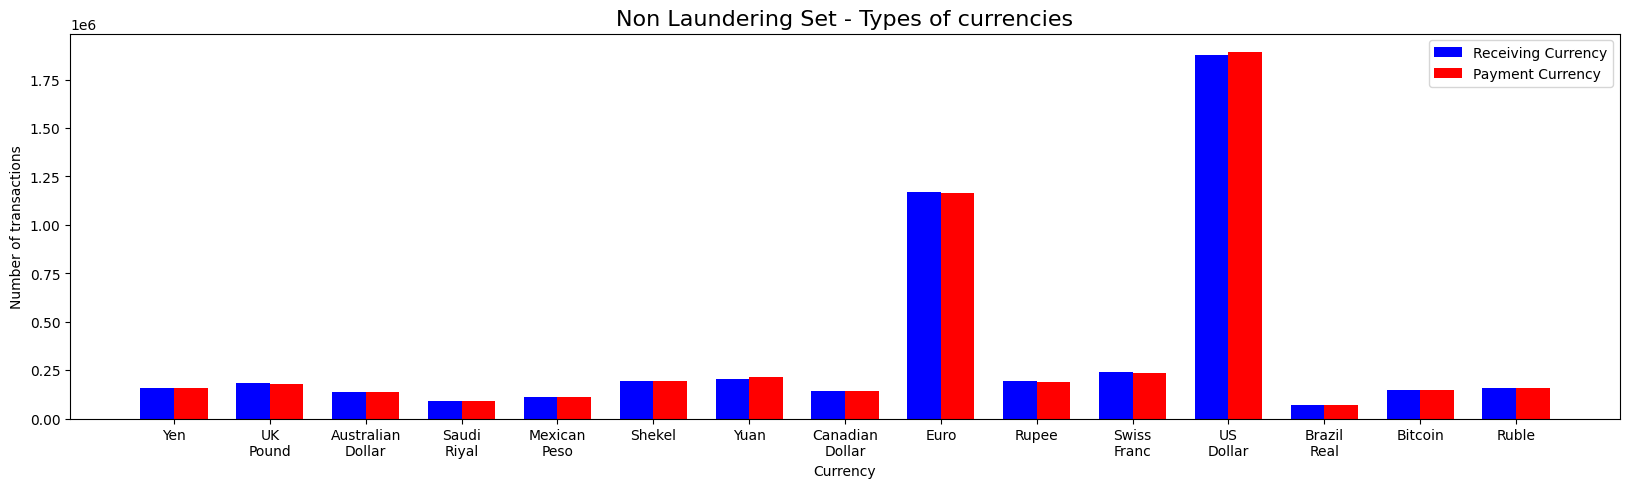

In [22]:
n_currencies(laundering, 'Laundering Set')
n_currencies(non_laundering, 'Non Laundering Set')

In [23]:
def plot_amounts(df, df_type):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.set_facecolor('white')
    group_by_type('receiving_currency', df, 'Receiving Currency - Pie Chart', ax1)
    group_by_type('payment_currency', df, 'Payment Currency - Pie Chart', ax2)
    fig.suptitle('{} - Currency Distribution'.format(df_type), fontsize=16)
    plt.tight_layout()
    plt.show()

def group_by_type(col, dataframe, title, ax):
    amount = dataframe.groupBy(col).count().sort(desc('count'))
    
    amount_df = amount.toPandas()
    counts = amount_df['count']
    
    labels = amount_df[col]
    draw_pie(counts, labels, title, ax)


def draw_pie(counts, labels, title, ax):
    wedges, l, _ = ax.pie(counts, labels=labels, autopct='', textprops={'color': 'k'})
    ax.set_title(title)

    percentages = [f'{val/sum(counts)*100:.1f}%' for val in counts]
    
    legend_labels = [f'{labels[i]}: {percentages[i]} ({counts[i]})' for i in range(len(labels))]
    ax.legend(wedges, legend_labels, title='Legend', loc='center left', bbox_to_anchor=(1.15, 0, 0.5, 1))

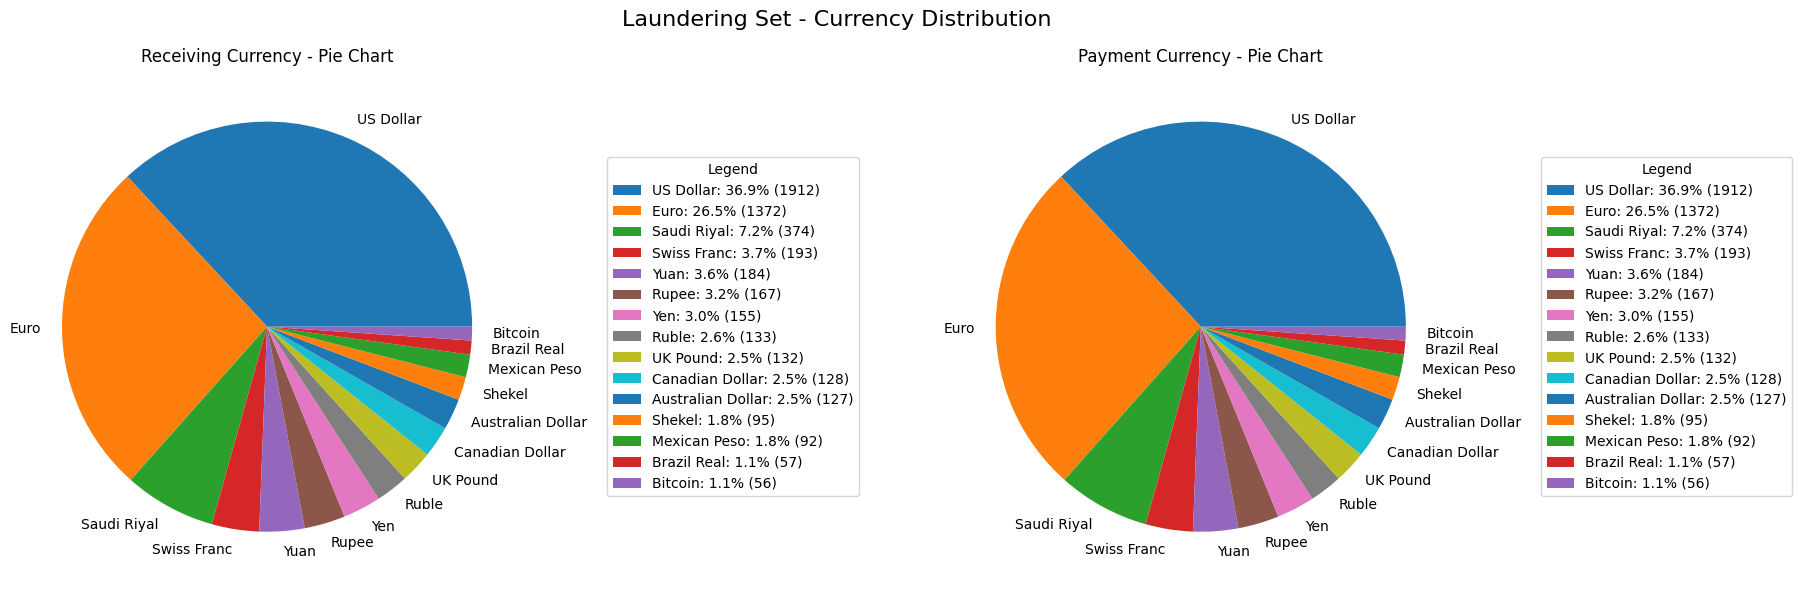

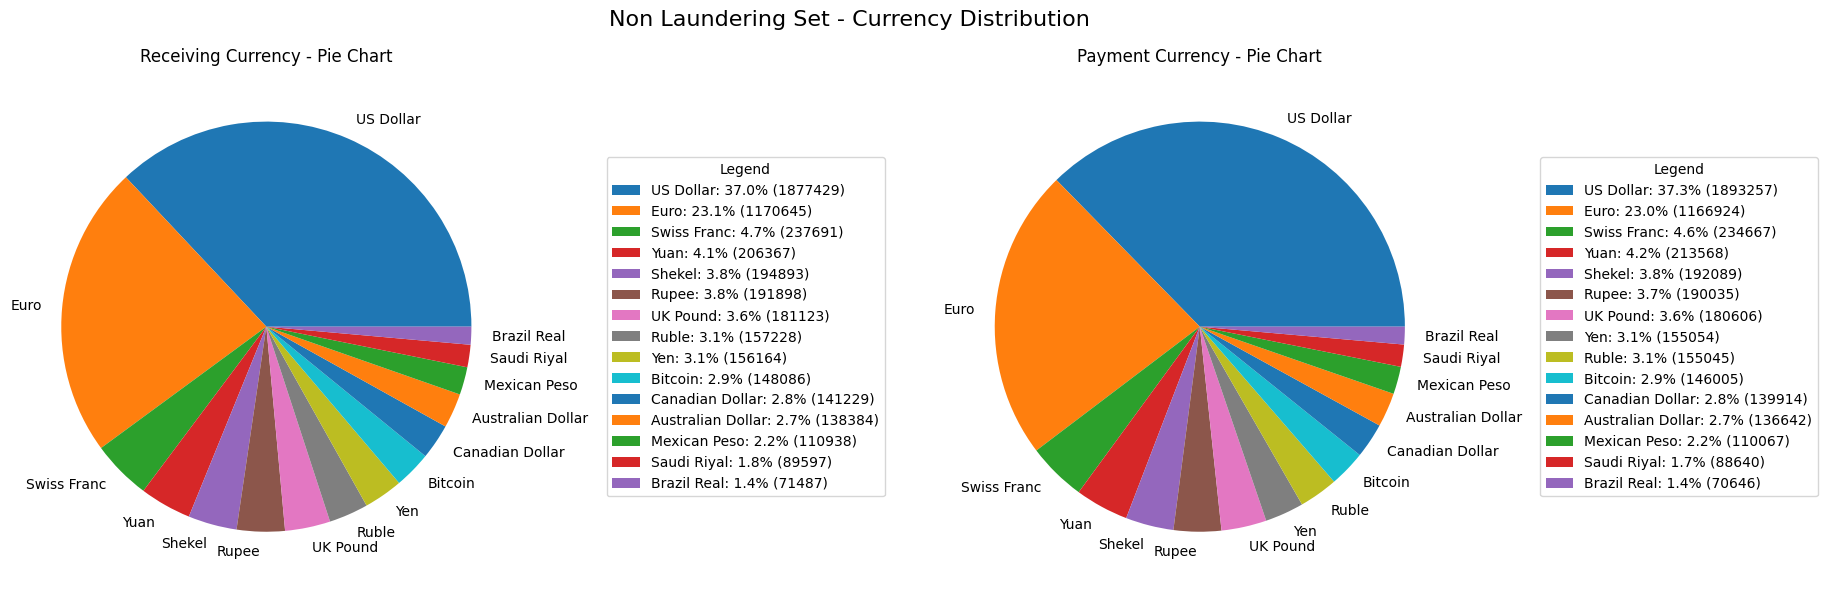

In [24]:
plot_amounts(laundering, 'Laundering Set')
plot_amounts(non_laundering, 'Non Laundering Set')

The types of receiving currency and payment currency have a very similar trend between the two classes

### 2.3 Summary

In [25]:
def get_summary(col1, col2, percentage):
    filtered_laundering = laundering.filter(col(col1) == col(col2)).count()
    filtered_non_laundering = non_laundering.filter(col(col1) == col(col2)).count()

    print(percentage)    
    
    print('Laundering set: ','{}%'.format(round((filtered_laundering*100/count_laundering),2)))
    print('Legitimate set: ','{}%'.format(round((filtered_non_laundering*100/count_non_laundering),2)),'\n')


In [26]:
get_summary('from_account', 'to_account', 'Percentage of self-pay transactions (same account)')
get_summary('from_bank', 'to_bank', 'Percentage of transactions to the same bank')
get_summary('receiving_currency', 'payment_currency', 'Percentage of transactions with the same currency')
get_summary('amount_received', 'amount_paid', 'Percentage of transactions with the same amounts')

Percentage of self-pay transactions (same account)
Laundering set:  0.21%
Legitimate set:  11.65% 

Percentage of transactions to the same bank
Laundering set:  1.99%
Legitimate set:  13.63% 

Percentage of transactions with the same currency
Laundering set:  100.0%
Legitimate set:  98.58% 

Percentage of transactions with the same amounts
Laundering set:  100.0%
Legitimate set:  98.58% 



In summary, through these analyses, key trends have been identified that help us better understand the behaviour of money laundering transactions and develop more effective strategies to detect and prevent them.

The analysis of the patterns present in the recycling transactions were analyzed in a different <a href="understand_pattern.ipynb">notebook</a>

## 3. Features Computing

### 3.1 Dataset sampling

Given the clean dataset, the following operations are performed:
- calculation of independent features in the complete dataset
- division of the dataset into the train and test set
- calculation of dependent features (for each dataset)
- dataset saving

In [27]:
class FeatureManager:
    def __init__(self, dataframe):
        self.origDF = dataframe
    
    def compute_features_of_whole_df(self):
        path = 'datasets/2_small_features.parquet'
        if not Path(path).exists():
            self.df_features = self.origDF\
                .withColumnRenamed('receiving_currency', 'rec_cur')\
                .withColumnRenamed('payment_currency', 'pay_cur')\
                .withColumnRenamed('payment_format', 'pay_for')\

            currencies = self.df_features.select('rec_cur').distinct().union(self.df_features.select('pay_cur').distinct())
            
            currency = StringIndexer(inputCol='rec_cur', outputCol='receiving_currency')
            payment_format = StringIndexer(inputCol='pay_for', outputCol='payment_format')
            
            rec_currency_model = currency.fit(currencies)
            self.df_features = rec_currency_model.transform(self.df_features)
            pay_currency_model = rec_currency_model.setInputCol('pay_cur').setOutputCol('payment_currency')
            self.df_features = pay_currency_model.transform(self.df_features)
            
            payment_format_model = payment_format.fit(self.df_features)
            self.df_features = payment_format_model.transform(self.df_features)
            self.ach_mapping = {v: k for k, v in dict(enumerate(payment_format_model.labels)).items()}
            
            column_order = ['id', 'timestamp',
                            'from_account','to_account','same_account',
                            'from_bank','to_bank','same_bank',
                            'amount_received','amount_paid','amount_difference','same_amounts',
                            'receiving_currency','payment_currency','same_currency',
                            'payment_format', 'is_laundering']
            
            self.df_features = self.df_features\
                    .withColumn('same_bank', (col('from_bank')==col('to_bank')).cast('integer'))\
                    .withColumn('same_account', (col('from_account')==col('to_account')).cast('integer'))\
                    .withColumn('same_currency', (col('receiving_currency')==col('payment_currency')).cast('integer'))\
                    .withColumn('same_amounts', (col('amount_received')==col('amount_paid')).cast('integer'))\
                    .withColumn('amount_difference', (col('amount_paid')-col('amount_received')))\
                    .select(column_order)

            self.df_features.write.parquet(path)
        else:
            self.df_features = spark.read.parquet(path, header=True)

    def compute_timestamp_features(self, df_type=True): # df_type = True (train), False (test)
        df = self.train_df if df_type else self.test_df
        
        df = df\
            .withColumn('week', weekofyear("timestamp"))\
            .withColumn('day_of_month', dayofmonth("timestamp"))\
            .withColumn('day_of_week', dayofweek("timestamp"))\
            .withColumn('hour', hour("timestamp"))

        hour_FA = df.groupBy('from_account','hour').agg(count('*').alias('transactions_same_hour_fa'))
        day_of_month_FA = df.groupBy('from_account','day_of_month').agg(count('*').alias('transactions_same_day_fa'))
        week_FA = df.groupBy('from_account','week').agg(count('*').alias('transactions_same_week_fa'))
        
        hour_FA_TA = df.groupBy('from_account','to_account', 'hour').agg(count('*').alias('transactions_same_hour_fata'))
        day_of_month_FA_TA = df.groupBy('from_account','to_account','day_of_month').agg(count('*').alias('transactions_same_day_fata'))
        week_FA_TA = df.groupBy('from_account','to_account','week').agg(count('*').alias('transactions_same_week_fata'))
        
        df = df\
            .join(hour_FA, ['from_account', 'hour'], 'left')\
            .join(day_of_month_FA, ['from_account', 'day_of_month'], 'left')\
            .join(week_FA, ['from_account', 'week'], 'left')\
            .join(hour_FA_TA, ['from_account', 'to_account', 'hour'], 'left')\
            .join(day_of_month_FA_TA, ['from_account', 'to_account', 'day_of_month'], 'left')\
            .join(week_FA_TA, ['from_account', 'to_account', 'week'], 'left')
        
        columns = df.columns
        # moving 'id' column in the first position
        columns.remove('id')
        columns.insert(0, 'id')
        # moving 'is_laundering' column in the last position
        columns.remove('is_laundering')
        columns.append('is_laundering')
        
        df = df.select(columns)

        if df_type:
            self.train_df = df
        else:
            self.test_df = df
       
    def split_with_undersampling(self, random_state=42):
        self.df_features = self.df_features.drop('from_bank','to_bank')
        launderings = self.df_features.filter('is_laundering==1')
        non_launderings = self.df_features.filter('is_laundering==0')
        
        # the random seed is set in such a way as to ensure reproducibility
        train_l, test_l = launderings.randomSplit([0.8, 0.2], seed=random_state)
        launderings_count = launderings.count()
        non_launderings_count = non_launderings.count()
        
        percentage_launderings = ceil(100*launderings_count/(launderings_count + non_launderings_count)) # 0.1%
        undersampling = launderings_count*90/10
        print(f'Laundering transactions are {percentage_launderings}% of the whole dataset ({launderings_count} transactions).\
                \nThe classes are unbalanced, so '+\
                f'the number of non legitimate transactions will be reduced to {int(undersampling)} (90% of the resulting dataset)')
        
        sample_non_laundering = non_launderings.orderBy(rand(seed=random_state)).limit(int(undersampling))
        train_nl, test_nl = sample_non_laundering.randomSplit([0.8, 0.2], seed=random_state)

        self.train_df = train_l.union(train_nl)
        self.test_df = test_l.union(test_nl)
        
        self.train_df.select('id').join(self.origDF, 'id', 'left').write.parquet('datasets/3_train_orig_features.parquet')
        self.test_df.select('id').join(self.origDF, 'id', 'left').write.parquet('datasets/3_test_orig_features.parquet')

    def save_dataframes(self, path):
        self.train_df.write.parquet(path.format('train_set'))
        self.test_df.write.parquet(path.format('test_set'))


The features that are calculated on the complete dataset are:
- same_bank 
- same_account
- same_currency 
- same_amounts 
- amount_difference

The first 4 features are worth either 0 or 1, while the last one represents the difference between the sum of money paid in a transaction and actually received.

In [28]:
cleaned_df = spark.read.parquet('datasets/1_cleaned_HI-Small.parquet')
manager = FeatureManager(cleaned_df)
manager.compute_features_of_whole_df()

A necessary action, due to the imbalance of the two classes, is an undersampling with respect to class of 0 (legitimate transactions), in fact laundering transactions represent 0.1% of the dataset.

The undersampling is done cosidering: 
- all the laundering transactions and splitting them with percentages of 80% and 20% in the corresponding sets (train and test set). In the resulting sets, those transactions will build the 1% of each set 
- a random sample of the legitimate set representing 10% of the corresponding train and test sets

In [29]:
manager.split_with_undersampling()
manager.compute_timestamp_features(df_type=True) # train set feature computing 
manager.compute_timestamp_features(df_type=False) # test set feature computing 
manager.save_dataframes('datasets/4_{}_noGF.parquet')

Laundering transactions are 1% of the whole dataset (5177 transactions).                
The classes are unbalanced, so the number of non legitimate transactions will be reduced to 46593 (90% of the resulting dataset)


In [30]:
def correlation_matrix(df):     
    columns = df.columns
    assembler = VectorAssembler(inputCols=columns, outputCol="features")
    feature_vector = assembler.transform(df)

    matrix = Correlation.corr(feature_vector, "features").collect()[0][0]
    corr_matrix = np.array(matrix.toArray())

    plt.figure(figsize=(20, 10))
    sns.heatmap(corr_matrix, xticklabels=columns, yticklabels=columns)

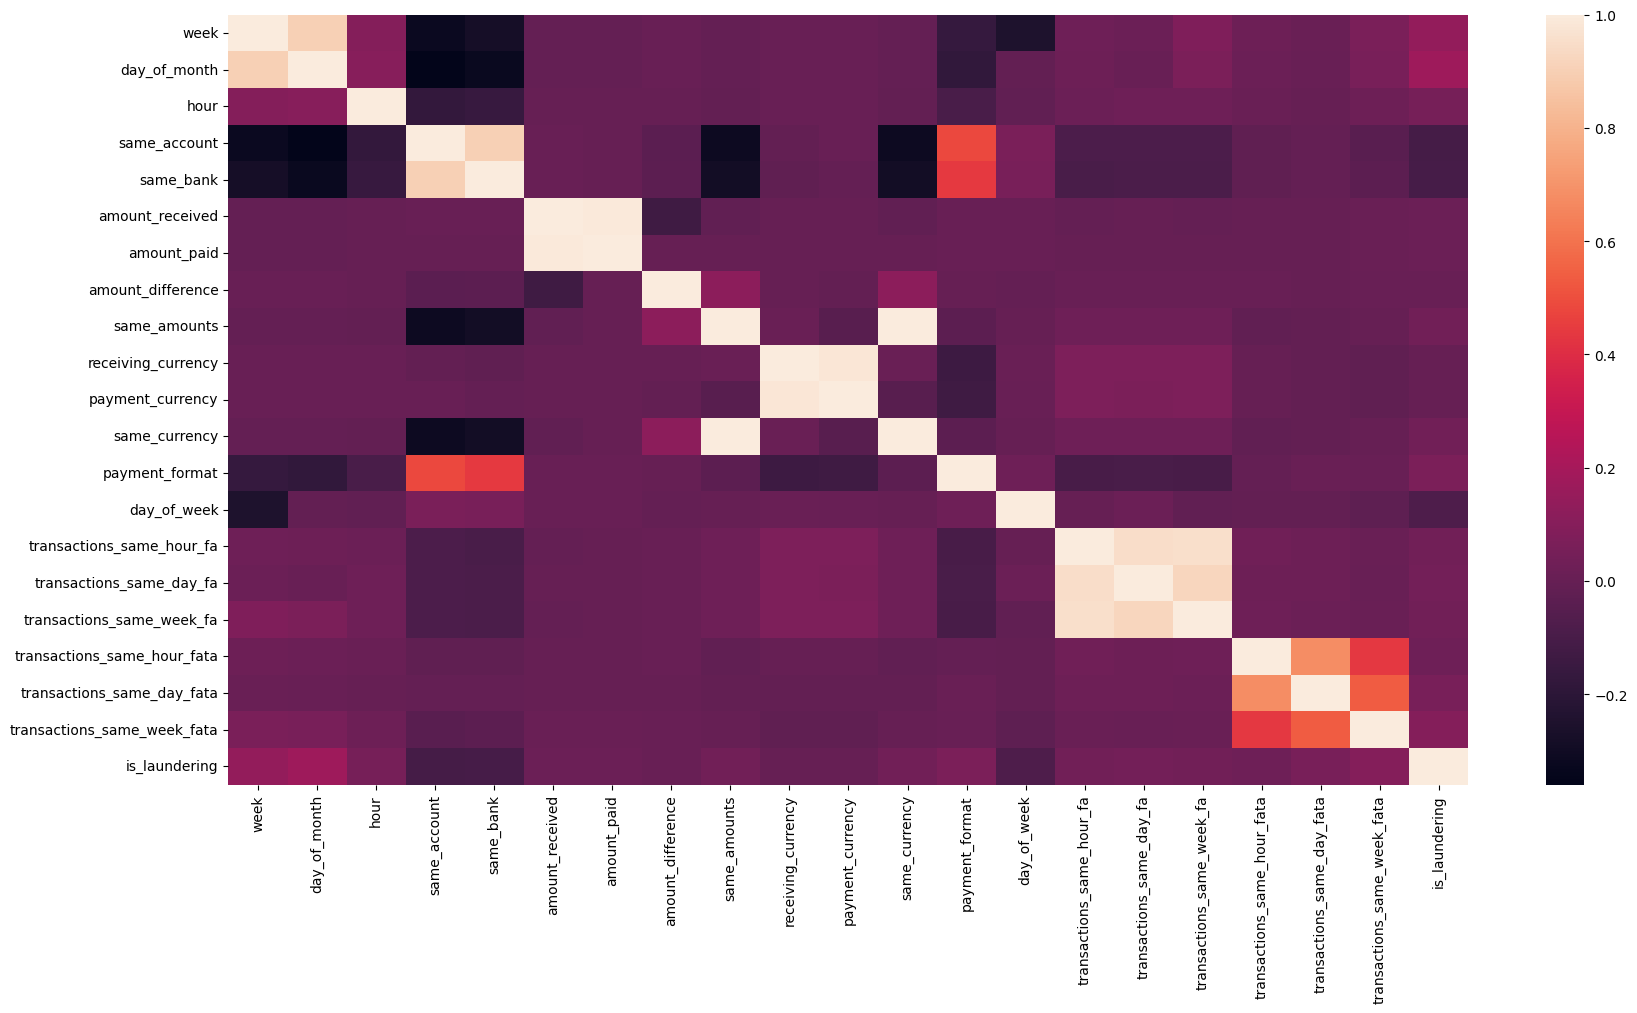

In [31]:
train_corr = manager.train_df.drop('id', 'from_account','to_account','timestamp')
correlation_matrix(train_corr)

### 3.2 Graphframes

As previously mentioned, this  <a href="understand_pattern.ipynb">notebook</a> was used for the analysis of patterns in the data.

The image below shows the types of patterns in the data

<img src="images/patterns.png" style="width: 600px">

The entire network of transactions can be represented as a real graph, in which the various accounts represent the nodes, while the connection edges between them represent the real transactions.

An Apache Spark library that allows you to process graphs in a distributed way is GraphFrames.

Looking at the image above, it would be beneficial to process certain features for each node in the graph to gain valuable insights into the transactions:
1. **Compute the number of in-out degree for each node** <br>
    For each account, it computes the number of ingoing and outgoing transactions   
2. **Check if there are any similar or equal transactions** <br>
    - Similar transactions are transactions between two accounts, having the same characteristics, but which took place at different times
    - Equal transactions, on the other hand, are transactions that took place at the same time between two accounts but with different amounts
3. **Detect forwarding transactions** <br>
    The forward flag is set to 1 if the receiver of the transaction sends the same amount of money to another account
4. **Check for intermediate transactions between two transactions** <br>
    Is an account the intermediary between two transactions?
5. **Fan-in, Fan-out** <br>
    A transaction involves an exchange between two accounts, and it would be valuable to calculate the connection degrees for each account:
    * In-out degrees for the sender account
    * In-out degrees for the receiver account
6. **PageRank** <br>
    It measures the importance of each node within the graph, based on the number incoming relationships and the importance of the corresponding source nodes
    
    
    $PR(p_i) = \frac{1 - d}{N} + d \sum_{p_j \in M(p_i)} \frac{PR(p_j)}{L(p_j)}$

    where: 
    * $PR(p_i)$ is the $p_i$ PageRank
    * $M(p_i)$ is the set of nodes that link to $p_i$
    * $L(p_j)$ is the number of outbound links on node $v$
    * $N$ is the total number of nodes
    * $d$ is the damping factor (resetProbability)
    

    

In [32]:
train = spark.read.parquet('datasets/4_train_set_noGF.parquet/')
test = spark.read.parquet('datasets/4_test_set_noGF.parquet/')
cleaned_df = spark.read.parquet('datasets/1_cleaned_HI-Small.parquet/')

In [33]:
train_orig_features = train.select('id').join(cleaned_df, 'id', 'left')
test_orig_features = test.select('id').join(cleaned_df, 'id', 'left')

In [34]:
from graphframes import *

class CustomGraph:
    # create the graph using the vertices and edges found in the dataset taken into account (train or test)
    def __init__(self, df):
        self.df = df
        self.ids = self.df.select('id','from_account','to_account')
        self.vertices, self.edges, self.g = self.create_graph()
        self.compute_inOut_degrees()

    def create_graph(self, init=True):
        vertices = self.df.select("from_account")\
                            .withColumnRenamed('from_account', 'id')\
                            .union(self.ids.select("to_account"))\
                            .distinct()
        if init:
            edges = self.df.withColumnRenamed('from_account', 'src')\
                .withColumnRenamed('to_account', 'dst')
        else:
            edges = self.df.withColumnRenamed('from_account', 'src')\
                .withColumnRenamed('to_account', 'dst').filter('from_account!=to_account and receiving_currency==payment_currency and payment_format="ACH"')\
                .select('id','timestamp','src','dst','payment_currency','payment_format')

        g = GraphFrame(vertices, edges)
        return vertices, edges, g

    def compute_inOut_degrees(self):
        # for each account, it computes the number of ingoing and outgoing transactions 
        vertexInDegrees = self.g.inDegrees
        vertexOutDegrees = self.g.outDegrees
        vertices = vertexInDegrees.join(vertexOutDegrees, 'id', 'fullouter').fillna(0)
        
        vertices = vertices.withColumnRenamed('id', 'from_account')
        self.ids = self.ids.alias('df').join(vertices.alias('vertices'), 'from_account', 'left')\
                        .withColumnRenamed('inDegree','from_account_inDegree')\
                        .withColumnRenamed('outDegree','from_account_outDegree')

        vertices = vertices.withColumnRenamed('from_account', 'to_account')
        self.ids = self.ids.join(vertices.alias('vertices'), 'to_account', 'left')\
                    .withColumnRenamed('inDegree','to_account_inDegree')\
                    .withColumnRenamed('outDegree','to_account_outDegree')

    def get_forwards(self):
        """
            it consists in getting all transactions in which the receiver of the transaction 
            sends the same amount of received money to another account
            OUTPUT: id of inolved transactions where:
            - before_forward: 1 if a transaction is that one before a secondly forwarding transaction
            - forward: 1 if a transaction is that one that makes the forward
        """
        motif = "(a)-[e]->(b); (b)-[e2]->(c)"
        forwards = self.g.find(motif).filter("e.amount_received == e2.amount_paid and e.timestamp <= e2.timestamp and a!=b and b!=c")
    
        before_forward = forwards.select(col('e.id').alias('id'))\
            .distinct()\
            .withColumn('before_forward',lit(1))
        # distinct: I can use it, or I can count how many times the id is involved
        forward = forwards.select(col('e2.id').alias('id'))\
            .distinct()\
            .withColumn('forward',lit(1))
        # distinct: I can use it, or I can count how many times the id is involved
    
        self.forwards = before_forward.join(forward, 'id','left')#.na.fill(value=0,subset=['before_forward','forward'])
     
    def same_or_similar(self):
        """
            it search if for each transaction there is:
            - another transaction with the same attributes, except the amounts (exists_same)
            - another transaction with similar attributes, except the timestamps and amounts (exists_similar)
        """
        motif = "(a)-[t1]->(b); (a)-[t2]->(b)"

        same_where = 't1.timestamp == t2.timestamp and \
                        t1.payment_currency == t2.payment_currency and \
                        t1.receiving_currency == t2.receiving_currency and \
                        t1.payment_format == t2.payment_format and \
                        t1.amount_paid != t2.amount_paid and \
                        t1.id != t2.id'
        
        self.same = self.g.find(motif).filter(same_where).select('t1.id').withColumn('exists_same',lit(1)).distinct()

        similar_where = 't1.timestamp != t2.timestamp and \
                        t1.payment_currency == t2.payment_currency and \
                        t1.receiving_currency == t2.receiving_currency and \
                        t1.payment_format == t2.payment_format and \
                        t1.amount_paid != t2.amount_paid'

        
        self.similar = self.g.find(motif).filter(similar_where).select('t1.id').withColumn('exists_similar',lit(1)).distinct()
########## START - FAN PATTERN ##########
    def compute_fan_in(self):
        """
            as explained in undestand_pattern.ipynb it is useful to compute the following feature: 
            - for each to_account, the number of incoming nodes to the same bank and all in node must have the same: 
                * receiving_currency 
                * payment_currency
                * payment_format
                * there must be at most 4 days between the first transaction and the last in the series
        """
        motif = "(a)-[t1]->(b); (c)-[t2]->(b)"
        
        fan_in_query = 'abs(datediff(t1.timestamp, t2.timestamp)) <= 4 and \
                    t1.payment_currency == t2.payment_currency and \
                    t1.receiving_currency == t2.receiving_currency and \
                    t1.payment_format == t2.payment_format'
                
        fan_in = self.g.find(motif).filter(fan_in_query).select('a', 'b', 't1')
        fan_in = fan_in.groupBy('a', 'b', 't1').count().select('t1.id',col('count').alias('fan_in_degree'))

        return fan_in

    def compute_fan_out(self):
        """
            as explained in undestand_pattern.ipynb it is useful to compute the following feature: 
            - for each from_account, the number of outgoing nodes to the same bank and all in node must have the same: 
                * payment_format
                * there must be at most 4 days between the first transaction and the last in the series
            
            in order to handle the big amount of data, data are firstly filtered:
            - self transaction (from_account == to_account) doesn't exist in the same fan-out
            - two similar transactions (t1(from_account, to_account) == t2(from_account, to_account) ) don't exist in the same fan-out 
            - fan-outs have ACH payment_format
        """
        _, _, g = self.create_graph(False)

        motif = "(a)-[t1]->(b); (a)-[t2]->(c)"
        
        fan_out_query = 'abs(datediff(t1.timestamp, t2.timestamp)) <= 4 and \
                        a != b and a != c and b != c and\
                        t1.id != t2.id'
                
        fan_out = g.find(motif).filter(fan_out_query).select('a', 'b', 'c', 't1.id')
        fan_out = fan_out.groupBy('a','b','c','id').count()
        fan_out = fan_out.groupBy('id').agg(count('*').alias('fan_out_degree')).select('id', 'fan_out_degree').withColumn('fan_out_degree', col('fan_out_degree')+1)
        
        return fan_out
    
    def compute_fan(self):
        fan_in = self.compute_fan_in()
        fan_out = self.compute_fan_out()  
        
        self.fans = fan_in.join(fan_out, 'id', 'fullouter')
########## END - FAN PATTERN ##########
    def page_rank(self):
        """
            - resetProbability: is the probability of reset to a random vertex during PageRank calculation. In other words, it represents the probability 
                that the user stops browsing on the current page and starts from a random page.
            - tol: the PageRank algorithm is run until the tolerance specified in tol has been reached. The tolerance represents the maximum allowable 
                difference between the PageRank scores of two successive iterations. This is useful if you wish to run the algorithm until PageRank converges 
                to a specified precision
        """
        res = self.g.pageRank(resetProbability=0.15, tol=0.1) 
        edges = res.edges.select('src','dst','weight','id')\
            .withColumnRenamed('src','from_account').withColumnRenamed('dst','to_account')\
            .withColumn('weight_t', _round(col('weight'),2))\
            .drop('weight')

        vertices = res.vertices.withColumn('page_rank', _round(col('pagerank'),2)).select('id','page_rank').withColumnRenamed('id','from_account')
        edges = vertices.join(edges, 'from_account', 'right').withColumnRenamed('page_rank','fa_pagerank')
        vertices = vertices.withColumnRenamed('from_account', 'to_account')
        edges = vertices.join(edges, 'to_account', 'right').withColumnRenamed('page_rank','ta_pagerank')\
            .select('id','fa_pagerank','ta_pagerank','weight_t')

        self.ids = self.ids.join(edges, 'id', 'left')

    def join_features(self):
        self.ids = self.ids.drop('from_account','to_account')
        self.ids = self.ids.join(self.forwards, 'id','left')
        self.ids = self.ids.join(self.similar, 'id', 'left').join(self.same, 'id', 'left')
        self.ids = self.ids.join(self.fans, 'id','left')

        self.df = self.df.join(self.ids, 'id', 'left').na.fill(value=0,subset=['exists_similar','forward','before_forward','exists_same']).na.fill(value=1,subset=['fan_out_degree', 'fan_in_degree'])

    def final_permutation_and_save(self, df_, df_type=True):
        self.df = self.df.drop('from_bank','from_account','timestamp','to_bank','to_account',\
            'receiving_currency','payment_currency','payment_format','is_laundering',\
            'amount_paid','amount_received')
        
        df_ = df_.drop('from_account','to_account','timestamp')
        self.df = self.df.join(df_, 'id', 'left')

        file_name = 'train' if df_type else 'test'            

        self.df.write.parquet('datasets/5_{}_set_withGF.parquet'.format(file_name))

In [35]:
def batch_graph(set_orig_features, set_no_GF, df_type=True):
    obj = CustomGraph(set_orig_features)
    obj.get_forwards()
    obj.same_or_similar()
    obj.compute_fan()
    obj.page_rank()
    obj.ids = obj.ids.cache()
    obj.join_features() 
    obj.final_permutation_and_save(set_no_GF, df_type)
    obj.ids.unpersist()

In [36]:
batch_graph(train_orig_features, train)
batch_graph(test_orig_features, test, df_type=False)

/Users/simonemalesardi/spark/python/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/Users/simonemalesardi/spark/python/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


### 3.3 Feature selection

The goals of feature selection are many, including dimensionality reduction within the feature space, speeding up the learning algorithm, improving the model performances, and reducing the risk of overfitting. 
Making feature selection before training a model is critical not only to these goals but also to effectively reduce the computational load of the modeling process. 

By isolating and retaining only the most relevant features, this process helps mitigate the dangers of overfitting, consequently leading to better generalization of the model. 

Therefore, the application of LogisticRegression as a feature selection technique allows for the identification of the most valuable set of features, which is subsequently employed in the construction of the DecisionTree model. 

This approach not only simplifies the learning process but also optimizes the predictive ability of the model to improve performance.

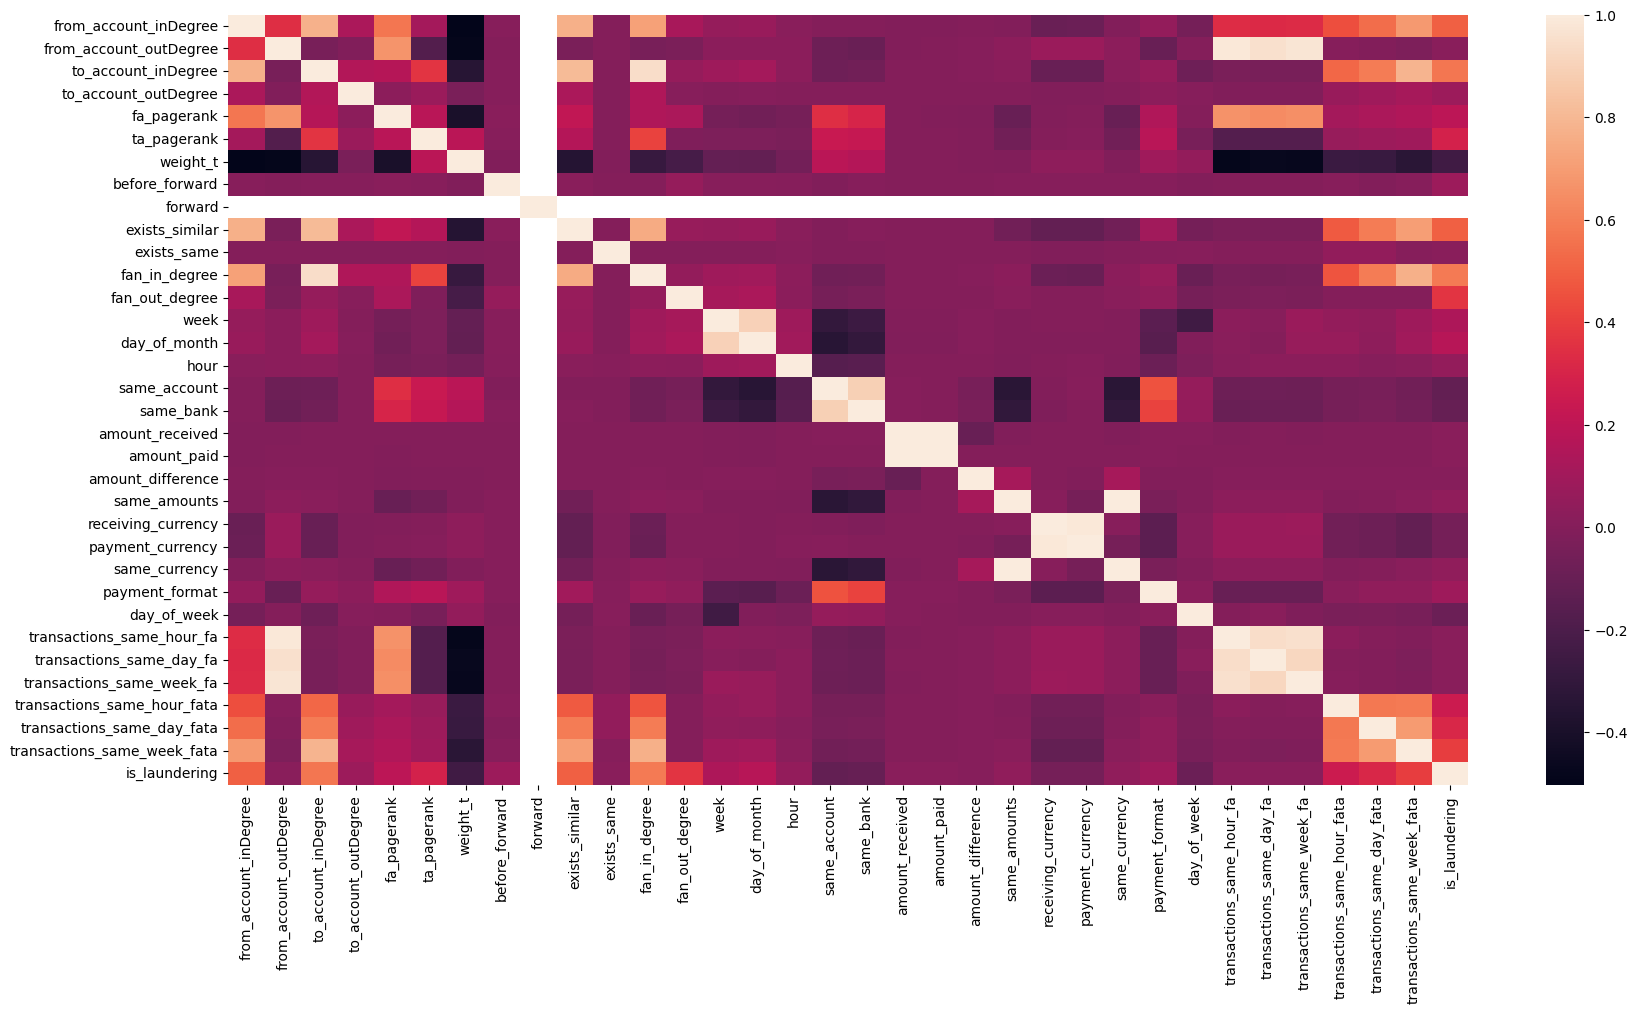

In [37]:
train_GF = spark.read.parquet('datasets/5_train_set_withGF.parquet')
test_GF = spark.read.parquet('datasets/5_test_set_withGF.parquet/')

correlation_matrix(train_GF.drop('id'))

In [38]:
def prepare_feature_selection(df, train=True):
    X, y = df.drop('id','is_laundering'), df.select('is_laundering')

    X_pd = X.toPandas()
    y_pd = y.toPandas().values.ravel()
    
    # normalization operation required before applying the model
    scaler = StandardScaler()
    X_pd[X_pd.columns] = scaler.fit_transform(X_pd[X_pd.columns])

    return X_pd, y_pd

In [39]:
X_train_pd, y_train_pd = prepare_feature_selection(train_GF)
X_test_pd, y_test_pd = prepare_feature_selection(test_GF, False)

The following code implements logistic regression with L1 regularization (Lasso) for feature selection. 
L1 regularization favors sparsity in the coefficients, forcing some of them to become exactly zero. 
This means that the model tends to make the coefficients of less relevant features exactly zero, effectively excluding them from the prediction.

The code loops over several values of parameter C (which controls the strength of the regularization), trains logistic regression models on a training set, evaluates performance on the test data, and returns metrics.
Also, the fit_log_reg function returns a DataFrame containing the coefficients of the features selected from the Lasso model.

In [40]:
def compute_log_reg(X_train_pd, y_train_pd, X_test_pd, y_test_pd, random_state=42):
    # listing all values I want to try as C value (regularization parameter)
    C=[1, 0.75, 0.50, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025]
    # intiate metric of zeros with 6 columns and rows equal to len(C)
    l1_metrics = np.zeros((len(C),6))
    # adding first column as value C
    l1_metrics[:,0]=C

    for index in range(0, len(C)):
        logreg = LogisticRegression(penalty='l1', C=C[index], solver='liblinear', random_state=random_state)
        logreg.fit(X_train_pd, y_train_pd)
        
        y_pred_pd = logreg.predict(X_test_pd)
        # Create non-zero count and all metrics columns
        l1_metrics[index,1] = np.count_nonzero(logreg.coef_)
        l1_metrics[index,2] = accuracy_score(y_test_pd, y_pred_pd)
        l1_metrics[index,3] = precision_score(y_test_pd, y_pred_pd)
        l1_metrics[index,4] = recall_score(y_test_pd, y_pred_pd)
        l1_metrics[index,5] = f1_score(y_test_pd, y_pred_pd)

    col_names = ['C','Non-Zero Coeffs','Accuracy','Precision','Recall','F1_score']
    return pd.DataFrame(l1_metrics, columns=col_names)
    
def fit_log_reg(C_value, X_train_pd, y_train_pd, random_state=42):
    #fitting Logistic Regression with C 0.1
    logreg = LogisticRegression(penalty='l1', C=C_value, solver='liblinear', random_state=random_state)
    logreg.fit(X_train_pd, y_train_pd)
    #call logreg.coef_ to get all coefficients
    #Lets use this to create data frame with Feature name & coefficient
    coef_df=pd.DataFrame(logreg.coef_,columns=X_train_pd.columns).T.reset_index()
    coef_df.columns=["Feature","Coef"]
    #Filter features with non zero coefficients and sort by coef value
    coef_df_final=coef_df[coef_df["Coef"]!=0].sort_values(by="Coef").reset_index(drop=True)
    #Lets print feature and its importance 
    return coef_df_final

In summary, these functions work together to compute and analyze the impact of different values of the regularization parameter C in Logistic Regression on feature selection. 

The compute_log_reg function computes various metrics for different C values, while the fit_log_reg function focuses on fitting the model and displaying the selected features along with their coefficients. This process helps identify the most valuable features and assess their importance in making predictions.

In [41]:
compute_log_reg(X_train_pd, y_train_pd, X_test_pd, y_test_pd)

,C,Non-Zero Coeffs,Accuracy,Precision,Recall,F1_score
0,1.0000,30.0,0.932054,0.809524,0.436697,0.567342
1,0.7500,28.0,0.932054,0.809524,0.436697,0.567342
2,0.5000,28.0,0.932054,0.809524,0.436697,0.567342
3,0.2500,28.0,0.931961,0.809199,0.435780,0.566488
4,0.1000,27.0,0.931961,0.810256,0.434862,0.565970
5,0.0500,27.0,0.932054,0.812715,0.433945,0.565789
6,0.0250,26.0,0.931306,0.809028,0.427523,0.559424
7,0.0100,22.0,0.929715,0.788756,0.424771,0.552177
8,0.0050,16.0,0.928591,0.781411,0.416514,0.543387
9,0.0025,11.0,0.929153,0.832335,0.382569,0.524199


In [42]:
coef_df_final = fit_log_reg(0.0050, X_train_pd, y_train_pd)
coef_df_final

,Feature,Coef
0,same_account,-0.589263
1,same_bank,-0.067878
2,day_of_week,-0.031750
3,exists_same,0.005678
4,hour,0.014834
5,amount_paid,0.018604
6,weight_t,0.105429
7,before_forward,0.109796
8,ta_pagerank,0.143162
9,fa_pagerank,0.185759


During the feature selection process using logistic regression, "amount_received" and "amount_paid" are among the features selected by the model.
However, in light of the goal of improving computational efficiency in training subsequent models, a thorough examination of the characteristics involved was performed.

In addition, a study on the correlation between the amounts and the classification label was conducted, using a correlation matrix. This analysis demonstrated that there is no direct correlation between the "amount_received" and "amount_paid" features and the label. 

The presence of the max_threshold parameter in the Decision Tree allows balancing the depth of the tree to avoid overfitting and long training times, but the decision to exclude the "amount_received" and "amount_paid" features is due to the fact that the inclusion of these features may make the model more susceptible to noise in the data.

In [43]:
reduced_features = coef_df_final['Feature'].tolist() + ['is_laundering']

if 'amount_received' in reduced_features: 
    reduced_features.remove('amount_received')
if 'amount_paid' in reduced_features: 
    reduced_features.remove('amount_paid')
    
train_GF.select(reduced_features).write.parquet('datasets/6_reduced_train_C.0050.parquet')
test_GF.select(reduced_features).write.parquet('datasets/6_reduced_test_C.0050.parquet')

## 4. ML models

The first part of this sections presents an overview of the Decision Tree implemented that is subsequently tested on a dataset that fits in memory.

In addition, the model is tested using the breast cancer dataset provided by sklearn.

Subsequently, an algorithm for selection of decision tree hyperparameters is used in such a way as to modify the performance of the model in order to obtain optimal results.

Finally there is the development of a Random Forest class that uses Spark to distribute the creation of trees on the different worker nodes.

In [44]:
def compute_metrics(y_test, y_pred): 
    tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
    tn = np.sum(np.logical_and(y_test == 0, y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    
    accuracy = round((tp+tn)/len(y_test), 2)

    recall = 0 if (tp == 0 and fn == 0) else round(tp/(tp+fn), 2)
    precision = 0 if (tp == 0 and fp == 0) else round(tp/(tp+fp), 2)
    f1_score = 0 if (recall == 0 and precision == 0) else round(
        2*(precision*recall)/(precision+recall), 2)

    metrics = f" * Accuracy: {accuracy}\n"+\
        f" * Recall: {recall}\n"+\
        f" * Precision: {precision}\n"+\
        f" * F1 score: {f1_score}"
    
    return [[tn, fp], [fn, tp]], metrics
    

def plot_confusion_matrix(confusion_matrix):
    plt.imshow(confusion_matrix,
                interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    fmt = 'd'
    thresh = np.max(confusion_matrix) / 2.
    for i, j in itertools.product(range(len(confusion_matrix[0])), range(len(confusion_matrix[1]))):
        plt.text(j, i, format(confusion_matrix[i][j], fmt),
                    horizontalalignment="center",
                    color="white" if confusion_matrix[i][j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### 4.1 Decision Tree

The following code provides a sequential (from scratch) implementation of the learning algorithm for a decision tree that is trained and tested with the two related sets obtained from the previous steps.

In [45]:
reduced_train = spark.read.parquet('datasets/6_reduced_train_C.0050.parquet/')
reduced_test = spark.read.parquet('datasets/6_reduced_test_C.0050.parquet/')

In [46]:
class Node:
    def __init__(self, feature=None, threshold=None, info_gain=None, left=None, right=None, value=None):
        """
        Create a Node object for a decision tree.
        
        Args:
            * feature (int): Index of the feature used for splitting at this node
            * threshold (float): Threshold value used to split the data
            * info_gain (float): Information gain achieved by the split
            * left (Node): The left child node
            * right (Node): The right child node
            * value (int): Value assigned to the leaf node (class label: 0 or 1)
        """
        self.feature = feature
        self.threshold = threshold
        self.info_gain = info_gain
        self.left = left
        self.right = right
        self.value = value  
    
    def is_leaf_node(self):
        return self.value is not None

In [47]:
class CustomDecisionTree:
    def __init__(self, max_n_features=None, split_criterion='gini', 
                 max_depth=None, min_samples_split=2, 
                 min_info_gain=0, max_thresholds=None, weights={}, 
                 random_state=None):       
        
        self.tree = None
        self.max_n_features = max_n_features
                    
        self.split_criterion = split_criterion

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
        self.min_info_gain = min_info_gain
        self.max_thresholds = max_thresholds
        self.weights = weights
        
        self.random_state = random_state
        if random_state is not None: 
            np.random.seed(self.random_state)

    ################################## TREE CONSTRUCTION ###################################
    def fit(self, X, y):        
        X = self.__check_dataframe(X)
        y = self.__check_dataframe(y, labels=True)
        
        self.tree = self.__grow_tree(X, y)
    
    def __check_dataframe(self, dataset, labels=False):
        if(isinstance(dataset, pd.DataFrame)):
            dataset = np.array(dataset) if not labels else np.array(dataset).flatten()
        
        return dataset

    def __grow_tree(self, X, y, depth=0):
        """
            Recursive method that takes as input the training set and the label set, returning as output the entire decision tree.
            The tree construction process begins with a root node that initially contains the entire input set. For each node under consideration, the following conditions are checked in order to determine whether the node should become a leaf of the tree:
            • are there only unique target classes in the data?
            • has the maximum depth of the tree (max_depth) been reached?
            • is the number of samples less than the minimum value required to continue splitting (min_samples_split)?
        
            If one of these conditions is met, the node becomes leaf and will contain the most common class among the considered data.
            Otherwise, if none of the conditions is met, the method searches for the best feature and split threshold by calling best_split, and then splits the node into two child nodes
        
        """
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (n_labels==1 or (self.max_depth != None and depth >= self.max_depth) or n_samples < self.min_samples_split):
            leaf_value = Counter(y).most_common(1)[0][0] # get the majority class 
            return Node(value=leaf_value)        

        best_feature, best_threshold, best_info_gain = self.__best_split(
            X, y)

        if(best_info_gain <= self.min_info_gain):
            leaf_value = Counter(y).most_common(1)[0][0] # get the majority class 
            return Node(value=leaf_value)      
          
        left_idxs = X[:, best_feature] <= best_threshold
        right_idxs = X[:, best_feature] > best_threshold

        left_node = self.__grow_tree(
            X[left_idxs], y[left_idxs], depth + 1)
        right_node = self.__grow_tree(
            X[right_idxs], y[right_idxs], depth + 1)

        if left_node.value != None and right_node.value != None and left_node.value == right_node.value:
            return Node(value=left_node.value)        

        return Node(feature=best_feature, threshold=best_threshold, info_gain=best_info_gain, left=left_node, right=right_node)
    
    def __best_split(self, X, y):
        """
            It takes as input the dataset and its labels. 
            Initially, it selects a random number of features to examine, which helps to prevent overfitting, and then it iterates over the selected features to calculate the feature index and split threshold that will allow the parent node to be split into two subsets in order to maximize the information gain (information_gain)
        """
        best_gain = -1
        split_idx, split_threshold = None, None
        
        feature_count = X.shape[1]
        
        np.random.seed(self.random_state) \
            if self.random_state is not None else np.random.seed(None)
            
        feat_idxs = self.__calculate_num_selected_features(feature_count)

        for feat_idx in feat_idxs:
            if self.max_thresholds is not None:
                if self.max_thresholds > 0:
                    thresholds = np.percentile(X[:, feat_idx], np.linspace(0, 100, self.max_thresholds))  
                    # linspace: it generates percentage points equally distributed between 0 and 100 considering the threshold
                    # percentile: calcola i percentile 
                else:
                    raise ValueError("The maximum threshold cannot be < 0")
            else:
                uniques = np.unique(X[:, feat_idx])
                thresholds = (uniques[1:] + uniques[:-1]) / 2

            for threshold in thresholds:
                info_gain = self.__information_gain(
                    X, y, feat_idx, threshold)
                
                if info_gain > best_gain:
                    best_gain = info_gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold, best_gain
    
    def __calculate_num_selected_features(self, feature_count):
        if self.max_n_features is None:
            num_selected_features = feature_count
        elif self.max_n_features == "sqrt":
            num_selected_features = int(math.sqrt(feature_count))
        elif self.max_n_features == "log2":
            num_selected_features = int(math.log2(feature_count))
        elif isinstance(self.max_n_features, int):
            num_selected_features = min(self.max_n_features, feature_count)
        
        return np.random.permutation(feature_count)[:num_selected_features]

    def __information_gain(self, X, y, feature, threshold):
        """
            It is a measure used to evaluate the importance of a feature in splitting the data.
            Higher information gain indicates that the feature is more informative and improves class separation in the data. The gini index and entropy are the criteria used to calculate the information gain.
            Specifically, the information gain is calculated as the entropy of the parent node minus the sum of the weighted entropies of the child nodes. The weight of a child node is given by the ratio of the number of samples in the child node to the total number of samples among all child nodes.
            Similarly information gain is calculated with gini score
        """        
        
        left_score = self.__calculate_splitting_criterion_node(X, y, feature, threshold)
        right_score = self.__calculate_splitting_criterion_node(X, y, feature, threshold, left=False)
        
        parent_score = self.__calculate_splitting_criterion(y)
        info_gain = parent_score - (left_score + right_score)
        return info_gain
    
    def __calculate_splitting_criterion_node(self, X, y, feature, threshold, left=True):
        indexes = X[:, feature] <= threshold if left else X[:, feature] > threshold
        labels = y[indexes]
        splitting_criterion = self.__calculate_splitting_criterion(labels)
        
        weighted_split = (
            len(labels) / len(y)) * splitting_criterion
        
        return weighted_split
    
    def __calculate_splitting_criterion(self, y):
        distinct_y, len_distinct_y = np.unique(y, return_counts=True)
        probability = len_distinct_y / len(y)

        if self.weights and distinct_y:
            weights = [self.weights.get(value, 1.0) for value in distinct_y]
            probability = probability * np.array(weights)
        
        
        split_criterion = 1 - np.sum(probability ** 2) \
            if self.split_criterion == 'gini' \
                else \
            np.sum(-probability * np.log2(probability + 1e-9))
    
        return split_criterion
    ################################## TREE CONSTRUCTION ###################################
    
    
    ###################################### PREDICTION ######################################
    def predict(self, X):
        X = self.__check_dataframe(X)
        self.y_pred = np.array([self.__explore_tree(x, self.tree) for x in X])
        return self.y_pred

    def __explore_tree(self, sample, node):
        """
        Check the current node based on the given sample.
        If the node has a value, it's a leaf node and returns its label.
        Otherwise, continue traversing the tree based on the sample's feature value.
        """                
        if node.is_leaf_node():
            return node.value
        
        if sample[node.feature] <= node.threshold:
            return self.__explore_tree(sample, node.left)
        else:
            return self.__explore_tree(sample, node.right)
    
    ###################################### PREDICTION ######################################

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return \
            {'max_n_features': self.max_n_features,
             'split_criterion': self.split_criterion,
             'max_depth': self.max_depth,
             'min_samples_split': self.min_samples_split,
             'max_thresholds': self.max_thresholds,
             'random_state': self.random_state}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    ######################################## REPORT ########################################
    def get_tree_depth(self):
        """
        Get the depth of the decision tree.
        """
        return self.__calculate_tree_depth(self.tree)
    
    def __calculate_tree_depth(self, node):
        """
        Recursively calculate the depth of the tree starting from a given node.
        """
        if node is None:
            return 0
        if node.left is None and node.right is None:
            return 1
        
        left_depth = self.__calculate_tree_depth(node.left)
        right_depth = self.__calculate_tree_depth(node.right)
        
        return max(left_depth, right_depth) + 1

    def get_report(self, compute_metrics): 
        report = "METRICS:\n" +  compute_metrics + \
            "\n\nREPORT:\n"+\
            f" * Split criterion: {self.split_criterion}\n"+\
            f" * Min samples split: {self.min_samples_split}\n"+\
            f" * Max features: {self.max_n_features}\n"+\
            f" * Max thresholds: {self.max_thresholds}\n"+\
            f" * Depth limit: {self.max_depth}\n"+\
            f" * Depth reached: {self.get_tree_depth()}\n"
            
        print(report)    
    ######################################## REPORT ########################################

In [48]:
train_pd = reduced_train.toPandas()
test_pd = reduced_test.toPandas()

X_cols = [x for x in train_pd.columns if x != 'is_laundering']
X_train, y_train = train_pd[X_cols], train_pd[['is_laundering']]
X_test, y_test = test_pd[X_cols], test_pd[['is_laundering']]

In [71]:
cdt = CustomDecisionTree(max_n_features='sqrt', max_depth=30, random_state=42)
cdt.fit(X_train, y_train)
cdt.predict(X_test)

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

METRICS:
 * Accuracy: 0.91
 * Recall: 0.66
 * Precision: 0.57
 * F1 score: 0.61

REPORT:
 * Split criterion: gini
 * Min samples split: 2
 * Max features: sqrt
 * Max thresholds: None
 * Depth limit: None
 * Depth reached: 9



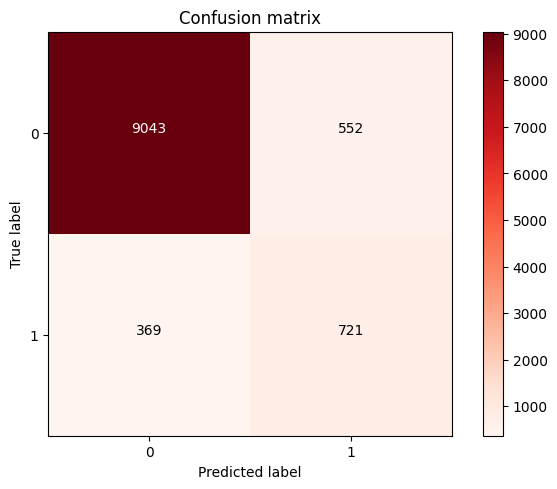

In [72]:
cdt_cm = compute_metrics(y_test.to_numpy().flatten(), cdt.y_pred)
cdt.get_report(cdt_cm[1])
plot_confusion_matrix(cdt_cm[0])

Overall, these results suggest that our Decision Tree model is effective in detecting suspicious money laundering transactions, with high accuracy and a good combination of recall and precision. However, further optimization or exploring other models could be considered to further improve performance.

#### 4.1.1 Testing Classifier
In order to demonstrate the effectiveness of the CustomDecisionTree algorithm, training and testing was conducted using the "breast\_cancer" dataset provided by Scikit-Learn. This dataset, similarly to the case of recycling transactions, is a binary dataset.

The model based on CustomDecisionTree obtained an F1 score of 96\%.

In addition, to evaluate the performance of the CustomDecisionTree model, a Scikit-Learn DecisionTreeClassifier model was trained and tested with the same data. 
This comparison showed how well the CustomDecisionTree model performs compared to the standard Scikit-Learn DecisionTreeClassifier model.


In [51]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

X_breast, y_breast = breast_cancer.data, breast_cancer.target
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_breast, y_breast, test_size=0.2, random_state=42)

breast_cancer_df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df['target'] = pd.Series(breast_cancer.target)

breast_cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


####  4.1.2 CustomDecisionTree vs sklearn DecisionTreeClassifier

The section shows how well CustomDecisionTree performs compared to sklearn DecisionTreeClassifier

 * Accuracy: 0.95
 * Recall: 0.96
 * Precision: 0.96
 * F1 score: 0.96


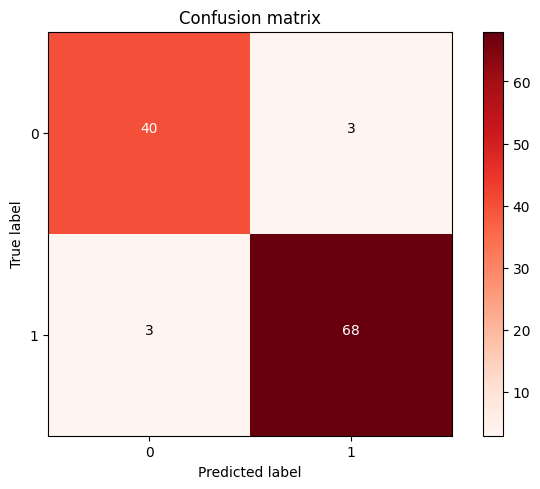

In [52]:
mdt_breast = CustomDecisionTree(random_state=42)
mdt_breast.fit(X_train_b, y_train_b)
mdt_breast.predict(X_test_b)
mdt_breast_cm = compute_metrics(y_test_b, mdt_breast.y_pred)
print(mdt_breast_cm[1])
plot_confusion_matrix(mdt_breast_cm[0])

 * Accuracy: 0.95
 * Recall: 0.96
 * Precision: 0.96
 * F1 score: 0.96


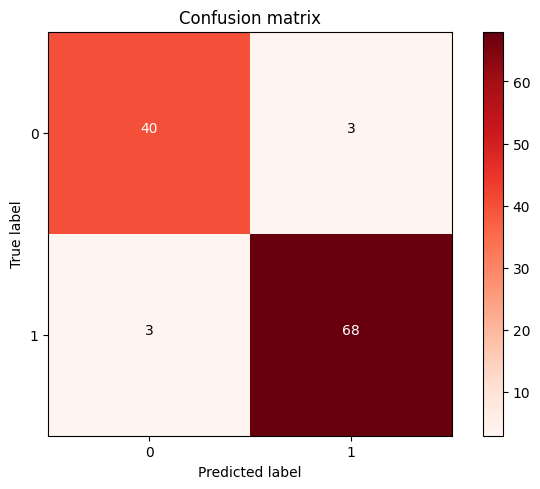

In [53]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_b, y_train_b)
y_pred = dtc.predict(X_test_b)
dtc_cm = compute_metrics(y_test_b, y_pred)
print(dtc_cm[1])
plot_confusion_matrix(dtc_cm[0])

The difference between the custom predictor and sklearn one is very small, so the custom class is considered to create the random forest with distributed workers.

### 4.2 Hyperparameter Tuning

<span style="color:green">GridSearchCV</span> and <span style="color:green">RandomizedSearchCV</span> are common hyperparameter search techniques used to optimize machine learning models.However, these techniques were not suitable for this case study:
- **GridSearchCV**: it is a very exhaustive technique as it examines all combinations of hyperparameters, but it can quickly become inefficient with a large number of hyperparameters to test, leading to a high computational load and a large execution time

- **RandomizedSearchCV**: unlike the first method, it does not examine all possible combinations, but performs the random search on a random subset of the possible combinations. It's faster than GridSearchCV, but it may not fully cover the hyperparameter space and you may miss important combinations

A different approach, but still based on cross validation is the HalvingGridSearchCV experimental method provided by sklearn.
This approach addresses the limitations of GridSearchCV and RandomizedSearchCV, providing the following advantages:
* Efficient use of resources: while GridSearchCV examines all combinations of hyperparameters, HalvingGridSearchCV intelligently narrows down the search space by iteratively selecting and refining the most promising combinations. This leads to a reduced computational load and shorter execution times

* Scalability: as the dataset grows, HalvingGridSearchCV remains efficient due to its focus on subsets of data and iterative refinement. This ensures that the method scales well even with large datasets

* Enhanced Generalization: By evaluating performance on multiple subsets of data, HalvingGridSearchCV aims to find hyperparameters that perform well across various scenarios, contributing to better model generalization.

HalvingGridSearchCV is designed to be efficient when you have a large number of hyperparameters to optimize and it works like this:
1. Divide the training data into smaller "subsets".
2. Start by testing combinations of hyperparameters on a small number of subsets.
3. Maintains only the best combinations of hyperparameters based on average performance on subsets of data.
4. Repeat the previous steps with an increasing number of subsets and a decreasing number of hyperparameter combinations.

In [54]:
clf = CustomDecisionTree(random_state=42)

params = {
    'max_n_features': ["sqrt", "log2", None],
    'split_criterion': ['entropy', 'gini'],
    'max_depth': [5, 10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'max_thresholds': [2, 5, 10, 15, None]
}
gs = HalvingGridSearchCV(clf, params, verbose=1, scoring='f1', random_state=np.random.seed(42))

# it ignores warning messages during fit operation
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gs.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 195
max_resources_: 47389
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 540
n_resources: 195
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
----------
iter: 1
n_candidates: 180
n_resources: 585
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 2
n_candidates: 60
n_resources: 1755
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 3
n_candidates: 20
n_resources: 5265
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 4
n_candidates: 7
n_resources: 15795
Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [55]:
best_params = gs.best_params_
best_params

{'max_depth': 10,
 'max_n_features': None,
 'max_thresholds': None,
 'min_samples_split': 10,
 'split_criterion': 'gini'}

### 4.3 RandomForest

The last step concerns the implementation of the random forest which allows the distribution of the work on different worker nodes. The number of workers is the same of the number of processor cores.

This implementation offers extensive customization options, with a key attribute being "bootstrap," which determines if random sampling with replacement occurs during tree creation. This means that for each tree, training data is randomly selected, potentially with duplicates.

Data is partitioned into specified segments (n_estimators), and the "train_tree" function is applied to each partition using "mapPartitions." The resulting CustomDecisionTree objects represent trained trees.
Trees are obtained with the "collect()" method, processing data partitions independently and yielding the final set of decision trees.

The test set is broadcast to worker nodes, and each decision tree is parallelized. Nodes make predictions using local test data.
Intermediate predictions are collected and aggregated on the driver node, with a majority voting mechanism used to generate final predictions.

Finally, the performance of the model with the related confusion matrix is ​​shown

In [56]:
reduced_train = spark.read.parquet('datasets/6_reduced_train_C.0050.parquet/')
reduced_test = pd.read_parquet('datasets/6_reduced_test_C.0050.parquet/')

 * Accuracy: 0.92
 * Recall: 0.58
 * Precision: 0.59
 * F1 score: 0.58


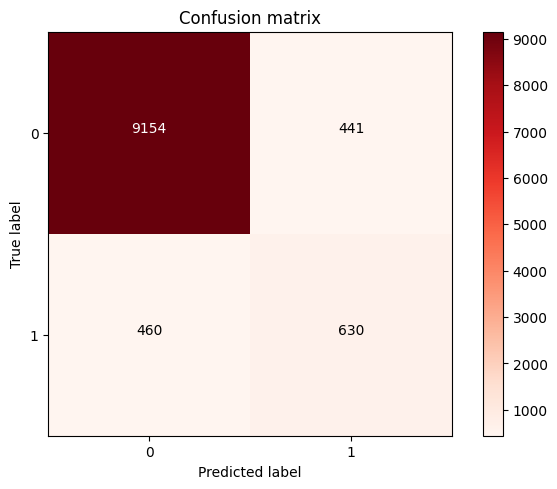

In [66]:
class CustomRandomForest:
    def __init__(self, n_estimators=40, split_criterion='gini', max_depth=20, 
                 max_n_features='sqrt', label='is_laundering', bootstrap=True, random_state=42):
        self.n_estimators = n_estimators
        self.split_criterion = split_criterion
        self.max_depth = max_depth
        self.max_n_features = max_n_features

        self.label = label

        self.bootstrap = bootstrap
        self.random_state = random_state

    def __train_tree(self, partition):
        sample = list(partition)
        df = pd.DataFrame(sample, columns=self.columns)
        X_train, y_train = df[self.features], df[self.label]
        tree = CustomDecisionTree(max_depth=self.max_depth, 
                                  split_criterion=self.split_criterion,
                                  max_n_features=self.max_n_features,
                                  random_state=self.random_state)
        
        tree.fit(X_train, y_train)

        yield tree
        
    def fit(self, train_set):
        self.columns = train_set.columns
        self.features = [x for x in self.columns if x != self.label]
        
        train_set = train_set.sample(True, 1.0, self.random_state) if self.bootstrap else train_set
        
        distributed_train_set = train_set.repartition(self.n_estimators)
        
        trees = distributed_train_set.rdd.mapPartitions(self.__train_tree)

        self.trees = trees.collect()

    def predict(self, sc, test_set):
        self.y_test = test_set[[self.label]] 
        
        broadcast_test_set = sc.broadcast(test_set)
        distributed_predictions = sc.parallelize(crf.trees).map(lambda tree: tree.predict(broadcast_test_set.value))
        
        predictions = distributed_predictions.collect()
        self.y_preds = np.array([Counter(col).most_common(1)[0][0] for col in zip(*predictions)])
        
    def evaluate(self):                
        conf_matrix = compute_metrics(self.y_test.to_numpy().flatten(), self.y_preds)
        print(conf_matrix[1])
        plot_confusion_matrix(conf_matrix[0])
     

crf = CustomRandomForest(n_estimators=40, random_state=42)
crf.fit(reduced_train)
crf.predict(spark.sparkContext, reduced_test)
crf.evaluate()

#### 4.3.1 pyspark RandomForestClassifier

 * Accuracy: 0.94
 * Recall: 0.47
 * Precision: 0.86
 * F1 score: 0.61


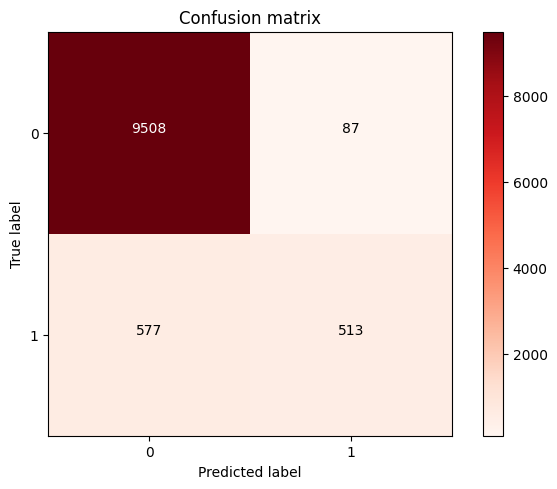

In [58]:
from pyspark.ml.classification import RandomForestClassifier

reduced_test_df = spark.createDataFrame(reduced_test) 

label = 'is_laundering'
feature_columns = [col for col in reduced_train.columns if col != label]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_train = assembler.transform(reduced_train).withColumnRenamed(label,'label')

rf = RandomForestClassifier(
    numTrees=40,
    maxDepth=30,
    subsamplingRate=0.8,
    impurity='gini',
    seed=42
)
model = rf.fit(assembled_train)

assembled_test = assembler.transform(reduced_test_df).withColumnRenamed(label,'label')
predictions = model.transform(assembled_test).select('label','prediction')

y_true = predictions.select("label").toPandas().values.flatten()
y_pred = predictions.select("prediction").toPandas().values.flatten()

conf_matrix = compute_metrics(y_true, y_pred)
print(conf_matrix[1])
plot_confusion_matrix(conf_matrix[0])